# Building a Better Visual Wake Words Dataset

## Introduction
This notebook trains and evaluates models for detecting whether an object is in an image. A custom dataset is built using images from the COCO Dataset. It is based on the Tensorflow Lite Micro walk through on building a person detector. A few changes to the underlying code have been made to correct bugs and make it easier to run. The original directions are available here:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/person_detection/training_a_model.md

More information on running the model that gets generated, can be found here: 
https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/person_detection

## Building the dataset
In order to train a person detector model, we need a large collection of images that are labeled depending on whether or not they have people in them. The ImageNet one-thousand class data that's widely used for training image classifiers doesn't include labels for people, but luckily the COCO dataset does. You can also download this data without manually registering too, and Slim provides a convenient script to grab it automatically.

This is a large download, about 40GB, so it will take a while and you'll need to make sure you have at least 100GB free on your drive to allow space for unpacking and further processing. The argument to the script is the path that the data will be downloaded to. If you change this, you'll also need to update the commands below that use it.

The dataset is designed to be used for training models for localization, so the images aren't labeled with the "contains a person", "doesn't contain a person" categories that we want to train for. Instead each image comes with a list of bounding boxes for all of the objects it contains. "Person" is one of these object categories, so to get to the classification labels we want, we have to look for images with bounding boxes for people. To make sure that they aren't too tiny to be recognizable we also need to exclude very small bounding boxes. Slim contains a script to convert the bounding box into labels.

Don't be surprised if this takes up to twenty minutes to complete. When it's done, you'll have a set of TFRecords in coco/processed holding the labeled image information. This data was created by Aakanksha Chowdhery and is known as the Visual Wake Words dataset. It's designed to be useful for benchmarking and testing embedded computer vision, since it represents a very common task that we need to accomplish with tight resource constraints. We're hoping to see it drive even better models for this and similar tasks.

## Model Configuration
The following parameters are used to configure the model that will be generated. A Movilenet V1 model architecture will be used. 

- **DATA_DIR** This is the directory where the COCO Dataset is downloaded and stored and the training/eval data TFRecords are created. The default for the Docker container is: /tf/dataset
- **TRAINING_DIR** This is the directory where model checkpoints are stored during training, and TFlite models are stored after conversion. The default for the Docker container is: /tf/training
- **TRAINING_NAME** This is the name of the directory used in the Training Dir for the current model.
- **CLASS_OF_INTEREST** This is the class of object, from the coco dataset that a detector will be built for.
- **IMAGE_SIZE** This is the size of the image that will be used. The MobileNet V1 Architecture can support the following image sizes: 96, 128, 160, 192, 224
- **USE_GRAYSCALE** Whether grayscale or color images should be used. It can be: True or False
- **SMALL_OBJECT_AREA_THRESHOLD** This is the minimum percentage an object's bounding box can be of the overall image area. The default is 0.005 or 0.5%. 

In [204]:
%env DATA_DIR = /tf/dataset
%env TRAINING_DIR = /tf/training
%env TRAINING_NAME = vww_128_color_bicycle_005
%env CLASS_OF_INTEREST=bicycle
%env IMAGE_SIZE=128
%env USE_GRAYSCALE=False
%env SMALL_OBJECT_AREA_THRESHOLD=0.005

env: DATA_DIR=/tf/dataset
env: TRAINING_DIR=/tf/training
env: TRAINING_NAME=vww_128_color_bicycle_005
env: CLASSES_OF_INTEREST=bicycle
env: AGGREGATE_CLASS_NAME=bicycle
env: IMAGE_SIZE=128
env: USE_GRAYSCALE=False
env: SMALL_OBJECT_AREA_THRESHOLD=0.005


### Building the dataset

In order to train a detector model the class of interest, we need a large collection of images
that are labeled depending on whether or not they have that class in them. The
ImageNet one-thousand class data that's widely used for training image
classifiers doesn't include labels for people, but luckily the
[COCO dataset](http://cocodataset.org/#home) does.

This is a large download, about 40GB, so it will take a while and you'll need
to make sure you have at least 100GB free on your drive to allow space for
unpacking and further processing. 

The dataset is designed to be used for training models for localization, so the
images aren't labeled with the "contains an object", "doesn't contain an object"
categories that we want to train for. Instead each image comes with a list of
bounding boxes for all of the objects it contains. To make sure that objects aren't
too tiny to be recognizable we also need to exclude very small bounding boxes.

Don't be surprised if this takes up to twenty minutes to complete. When it's
done, you'll have a set of TFRecords in `coco/processed` holding the labeled
image information. This data was created by Aakanksha Chowdhery and is known as
the [Visual Wake Words dataset](https://arxiv.org/abs/1906.05721). It's designed
to be useful for benchmarking and testing embedded computer vision, since it
represents a very common task that we need to accomplish with tight resource
constraints. We're hoping to see it drive even better models for this and
similar tasks.

In [183]:
!python /tf/models/research/slim/download_and_convert_data.py \
    --dataset_name=visualwakewords \
    --dataset_dir="${DATA_DIR}" \
    --foreground_class_of_interest="${CLASS_OF_INTEREST}" \
    --small_object_area_threshold=${SMALL_OBJECT_AREA_THRESHOLD}

INFO:tensorflow:Using Forground Class of interest: ['apple']
I1030 19:21:37.138067 139945417221952 download_and_convert_data.py:83] Using Forground Class of interest: ['apple']
File train2014.zip has been already downloaded at /tf/dataset/coco_dataset/train2014.zip. Unzipping it....
File val2014.zip has been already downloaded at /tf/dataset/coco_dataset/val2014.zip. Unzipping it....
File annotations_trainval2014.zip has been already downloaded at /tf/dataset/coco_dataset/annotations_trainval2014.zip. Unzipping it....
INFO:tensorflow:Creating a labels file...
I1030 19:21:40.486806 139945417221952 download_and_convert_visualwakewords.py:131] Creating a labels file...
INFO:tensorflow:Creating train VisualWakeWords annotations...
I1030 19:21:40.487199 139945417221952 download_and_convert_visualwakewords.py:136] Creating train VisualWakeWords annotations...
INFO:tensorflow:Building annotations index... for categories: [53]
I1030 19:21:55.043738 139945417221952 download_and_convert_visualwa

## Train Model

One of the nice things about using tf.slim to handle the training is that the parameters you commonly need to modify are available as command line arguments, so we can just call the standard train_image_classifier.py script to train our model.

This will take a couple of days on a single-GPU v100 instance to complete all one-million steps, but you should be able to get a fairly accurate model after a few hours if you want to experiment early.

- The checkpoints and summaries will the saved in the folder given in the --train_dir argument, so that's where you'll have to look for the results.

- The --dataset_dir parameter should match the one where you saved the TFRecords from the Visual Wake Words build script.

- The architecture we'll be using is defined by the --model_name argument. The 'mobilenet_v1' prefix tells the script to use the first version of MobileNet. We did experiment with later versions, but these used more RAM for their intermediate activation buffers, so for now we kept with the original. The '025' is the depth multiplier to use, which mostly affects the number of weight parameters, this low setting ensures the model fits within 250KB of Flash.
- --preprocessing_name controls how input images are modified before they're fed into the model. The 'mobilenet_v1' version shrinks the width and height of the images to the size given in --train_image_size (in our case 96 pixels since we want to reduce the compute requirements). It also scales the pixel values from 0 to 255 integers into -1.0 to +1.0 floating point numbers (though we'll be quantizing those after training).

- The --input_grayscale flag configures whether images are converted to grayscale during preprocessing.

- The --learning_rate, --label_smoothing, --learning_rate_decay_factor, --num_epochs_per_decay, --moving_average_decay and --batch_size are all parameters that control how weights are updated during the the training process. Training deep networks is still a bit of a dark art, so these exact values we found through experimentation for this particular model. You can try tweaking them to speed up training or gain a small boost in accuracy, but we can't give much guidance for how to make those changes, and it's easy to get combinations where the training accuracy never converges.

- The --max_number_of_steps defines how long the training should continue. There's no good way to figure out this threshold in advance, you have to experiment to tell when the accuracy of the model is no longer improving to tell when to cut it off. In our case we default to a million steps, since with this particular model we know that's a good point to stop.


In [ ]:
! python /tf/models/research/slim/train_image_classifier.py \
    --train_dir="${TRAINING_DIR}/${TRAINING_NAME}" \
    --dataset_name=visualwakewords \
    --dataset_split_name=train \
    --dataset_dir="${DATA_DIR}"  \
    --model_name=mobilenet_v1_025 \
    --preprocessing_name=mobilenet_v1 \
    --train_image_size=${IMAGE_SIZE} \
    --use_grayscale=${USE_GRAYSCALE} \
    --save_summaries_secs=300 \
    --learning_rate=0.045 \
    --label_smoothing=0.1 \
    --learning_rate_decay_factor=0.98 \
    --num_epochs_per_decay=2.5 \
    --moving_average_decay=0.9999 \
    --batch_size=96 \
    --max_number_of_steps=1000000 

Instructions for updating:
Please switch to tf.train.create_global_step
W1016 13:31:18.466224 139809028818752 deprecation.py:323] From /tf/models/research/slim/train_image_classifier.py:430: create_global_step (from tf_slim.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.create_global_step
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
W1016 13:31:18.473891 139809028818752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/data/parallel_reader.py:249: string_input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
W1016 13:31:19.959772 139809028818752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/losses/loss_ops.py:155: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1016 13:31:19.961765 139809028818752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/losses/loss_ops.py:157: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use tf.losses.add_loss instead.
W1016 13:31:19.969563 139809028818752 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/losses/loss_ops.py:124

INFO:tensorflow:Running local_init_op.
I1016 13:31:30.359938 139809028818752 session_manager.py:500] Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I1016 13:31:30.550281 139809028818752 session_manager.py:502] Done running local_init_op.
INFO:tensorflow:Starting Session.
I1016 13:31:35.784170 139809028818752 learning.py:746] Starting Session.
INFO:tensorflow:Saving checkpoint to path /tf/training/vww_96_gray_car_005/model.ckpt
I1016 13:31:35.949426 139791312086784 supervisor.py:1117] Saving checkpoint to path /tf/training/vww_96_gray_car_005/model.ckpt
INFO:tensorflow:Starting Queues.
I1016 13:31:35.956803 139809028818752 learning.py:760] Starting Queues.
INFO:tensorflow:global_step/sec: 0
I1016 13:31:38.809615 139791320479488 supervisor.py:1099] global_step/sec: 0
2020-10-16 13:31:41.413188: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-10-16 13:31:43.040411: I tensorflow/stream_executor/platf

INFO:tensorflow:global step 430: loss = 0.3934 (0.180 sec/step)
I1016 13:33:04.027046 139809028818752 learning.py:512] global step 430: loss = 0.3934 (0.180 sec/step)
INFO:tensorflow:global step 440: loss = 0.4143 (0.190 sec/step)
I1016 13:33:05.932538 139809028818752 learning.py:512] global step 440: loss = 0.4143 (0.190 sec/step)
INFO:tensorflow:global step 450: loss = 0.3631 (0.185 sec/step)
I1016 13:33:07.794149 139809028818752 learning.py:512] global step 450: loss = 0.3631 (0.185 sec/step)
INFO:tensorflow:global step 460: loss = 0.4519 (0.177 sec/step)
I1016 13:33:09.688847 139809028818752 learning.py:512] global step 460: loss = 0.4519 (0.177 sec/step)
INFO:tensorflow:global step 470: loss = 0.3520 (0.197 sec/step)
I1016 13:33:11.588646 139809028818752 learning.py:512] global step 470: loss = 0.3520 (0.197 sec/step)
INFO:tensorflow:global step 480: loss = 0.4129 (0.181 sec/step)
I1016 13:33:13.474750 139809028818752 learning.py:512] global step 480: loss = 0.4129 (0.181 sec/step

INFO:tensorflow:global step 930: loss = 0.3764 (0.192 sec/step)
I1016 13:34:38.539855 139809028818752 learning.py:512] global step 930: loss = 0.3764 (0.192 sec/step)
INFO:tensorflow:global step 940: loss = 0.4191 (0.190 sec/step)
I1016 13:34:40.447984 139809028818752 learning.py:512] global step 940: loss = 0.4191 (0.190 sec/step)
INFO:tensorflow:global step 950: loss = 0.2825 (0.191 sec/step)
I1016 13:34:42.335508 139809028818752 learning.py:512] global step 950: loss = 0.2825 (0.191 sec/step)
INFO:tensorflow:global step 960: loss = 0.3490 (0.187 sec/step)
I1016 13:34:44.240954 139809028818752 learning.py:512] global step 960: loss = 0.3490 (0.187 sec/step)
INFO:tensorflow:global step 970: loss = 0.4119 (0.181 sec/step)
I1016 13:34:46.143519 139809028818752 learning.py:512] global step 970: loss = 0.4119 (0.181 sec/step)
INFO:tensorflow:global step 980: loss = 0.2695 (0.195 sec/step)
I1016 13:34:48.061161 139809028818752 learning.py:512] global step 980: loss = 0.2695 (0.195 sec/step

INFO:tensorflow:global step 1420: loss = 0.5030 (0.183 sec/step)
I1016 13:36:11.644264 139809028818752 learning.py:512] global step 1420: loss = 0.5030 (0.183 sec/step)
INFO:tensorflow:global step 1430: loss = 0.3538 (0.194 sec/step)
I1016 13:36:13.526314 139809028818752 learning.py:512] global step 1430: loss = 0.3538 (0.194 sec/step)
INFO:tensorflow:global step 1440: loss = 0.4013 (0.186 sec/step)
I1016 13:36:15.424905 139809028818752 learning.py:512] global step 1440: loss = 0.4013 (0.186 sec/step)
INFO:tensorflow:global step 1450: loss = 0.3680 (0.191 sec/step)
I1016 13:36:17.342764 139809028818752 learning.py:512] global step 1450: loss = 0.3680 (0.191 sec/step)
INFO:tensorflow:global step 1460: loss = 0.3347 (0.173 sec/step)
I1016 13:36:19.258803 139809028818752 learning.py:512] global step 1460: loss = 0.3347 (0.173 sec/step)
INFO:tensorflow:global step 1470: loss = 0.3592 (0.181 sec/step)
I1016 13:36:21.137045 139809028818752 learning.py:512] global step 1470: loss = 0.3592 (0.

INFO:tensorflow:global step 1890: loss = 0.4453 (0.195 sec/step)
I1016 13:37:40.844032 139809028818752 learning.py:512] global step 1890: loss = 0.4453 (0.195 sec/step)
INFO:tensorflow:global step 1900: loss = 0.3782 (0.187 sec/step)
I1016 13:37:42.769762 139809028818752 learning.py:512] global step 1900: loss = 0.3782 (0.187 sec/step)
INFO:tensorflow:global step 1910: loss = 0.3911 (0.183 sec/step)
I1016 13:37:44.667287 139809028818752 learning.py:512] global step 1910: loss = 0.3911 (0.183 sec/step)
INFO:tensorflow:global step 1920: loss = 0.4210 (0.185 sec/step)
I1016 13:37:46.560809 139809028818752 learning.py:512] global step 1920: loss = 0.4210 (0.185 sec/step)
INFO:tensorflow:global step 1930: loss = 0.4151 (0.184 sec/step)
I1016 13:37:48.456949 139809028818752 learning.py:512] global step 1930: loss = 0.4151 (0.184 sec/step)
INFO:tensorflow:global step 1940: loss = 0.3709 (0.185 sec/step)
I1016 13:37:50.336802 139809028818752 learning.py:512] global step 1940: loss = 0.3709 (0.

INFO:tensorflow:global step 2380: loss = 0.3644 (0.195 sec/step)
I1016 13:39:13.894906 139809028818752 learning.py:512] global step 2380: loss = 0.3644 (0.195 sec/step)
INFO:tensorflow:global step 2390: loss = 0.3937 (0.182 sec/step)
I1016 13:39:15.755509 139809028818752 learning.py:512] global step 2390: loss = 0.3937 (0.182 sec/step)
INFO:tensorflow:global step 2400: loss = 0.3434 (0.198 sec/step)
I1016 13:39:17.657157 139809028818752 learning.py:512] global step 2400: loss = 0.3434 (0.198 sec/step)
INFO:tensorflow:global step 2410: loss = 0.4221 (0.192 sec/step)
I1016 13:39:19.519141 139809028818752 learning.py:512] global step 2410: loss = 0.4221 (0.192 sec/step)
INFO:tensorflow:global step 2420: loss = 0.4598 (0.181 sec/step)
I1016 13:39:21.417242 139809028818752 learning.py:512] global step 2420: loss = 0.4598 (0.181 sec/step)
INFO:tensorflow:global step 2430: loss = 0.3693 (0.182 sec/step)
I1016 13:39:23.286251 139809028818752 learning.py:512] global step 2430: loss = 0.3693 (0.

INFO:tensorflow:global step 2870: loss = 0.4903 (0.191 sec/step)
I1016 13:40:46.637999 139809028818752 learning.py:512] global step 2870: loss = 0.4903 (0.191 sec/step)
INFO:tensorflow:global step 2880: loss = 0.3621 (0.193 sec/step)
I1016 13:40:48.552533 139809028818752 learning.py:512] global step 2880: loss = 0.3621 (0.193 sec/step)
INFO:tensorflow:global step 2890: loss = 0.3110 (0.180 sec/step)
I1016 13:40:50.464314 139809028818752 learning.py:512] global step 2890: loss = 0.3110 (0.180 sec/step)
INFO:tensorflow:global step 2900: loss = 0.3269 (0.178 sec/step)
I1016 13:40:52.336231 139809028818752 learning.py:512] global step 2900: loss = 0.3269 (0.178 sec/step)
INFO:tensorflow:global step 2910: loss = 0.3683 (0.180 sec/step)
I1016 13:40:54.208318 139809028818752 learning.py:512] global step 2910: loss = 0.3683 (0.180 sec/step)
INFO:tensorflow:global step 2920: loss = 0.3227 (0.182 sec/step)
I1016 13:40:56.104785 139809028818752 learning.py:512] global step 2920: loss = 0.3227 (0.

INFO:tensorflow:global step 3330: loss = 0.4095 (0.195 sec/step)
I1016 13:42:14.608107 139809028818752 learning.py:512] global step 3330: loss = 0.4095 (0.195 sec/step)
INFO:tensorflow:global step 3340: loss = 0.3708 (0.192 sec/step)
I1016 13:42:16.514503 139809028818752 learning.py:512] global step 3340: loss = 0.3708 (0.192 sec/step)
INFO:tensorflow:global step 3350: loss = 0.3735 (0.205 sec/step)
I1016 13:42:18.413088 139809028818752 learning.py:512] global step 3350: loss = 0.3735 (0.205 sec/step)
INFO:tensorflow:global step 3360: loss = 0.4523 (0.190 sec/step)
I1016 13:42:20.304818 139809028818752 learning.py:512] global step 3360: loss = 0.4523 (0.190 sec/step)
INFO:tensorflow:global step 3370: loss = 0.3558 (0.184 sec/step)
I1016 13:42:22.181231 139809028818752 learning.py:512] global step 3370: loss = 0.3558 (0.184 sec/step)
INFO:tensorflow:global step 3380: loss = 0.3998 (0.195 sec/step)
I1016 13:42:24.092482 139809028818752 learning.py:512] global step 3380: loss = 0.3998 (0.

INFO:tensorflow:global step 3820: loss = 0.3848 (0.188 sec/step)
I1016 13:43:47.051676 139809028818752 learning.py:512] global step 3820: loss = 0.3848 (0.188 sec/step)
INFO:tensorflow:global step 3830: loss = 0.3239 (0.188 sec/step)
I1016 13:43:48.944524 139809028818752 learning.py:512] global step 3830: loss = 0.3239 (0.188 sec/step)
INFO:tensorflow:global step 3840: loss = 0.2855 (0.188 sec/step)
I1016 13:43:50.850576 139809028818752 learning.py:512] global step 3840: loss = 0.2855 (0.188 sec/step)
INFO:tensorflow:global step 3850: loss = 0.4402 (0.187 sec/step)
I1016 13:43:52.753000 139809028818752 learning.py:512] global step 3850: loss = 0.4402 (0.187 sec/step)
INFO:tensorflow:global step 3860: loss = 0.4249 (0.184 sec/step)
I1016 13:43:54.660402 139809028818752 learning.py:512] global step 3860: loss = 0.4249 (0.184 sec/step)
INFO:tensorflow:global step 3870: loss = 0.2939 (0.187 sec/step)
I1016 13:43:56.601544 139809028818752 learning.py:512] global step 3870: loss = 0.2939 (0.

INFO:tensorflow:global step 4310: loss = 0.4351 (0.194 sec/step)
I1016 13:45:20.167789 139809028818752 learning.py:512] global step 4310: loss = 0.4351 (0.194 sec/step)
INFO:tensorflow:global step 4320: loss = 0.3851 (0.191 sec/step)
I1016 13:45:22.039982 139809028818752 learning.py:512] global step 4320: loss = 0.3851 (0.191 sec/step)
INFO:tensorflow:global step 4330: loss = 0.3555 (0.182 sec/step)
I1016 13:45:23.901355 139809028818752 learning.py:512] global step 4330: loss = 0.3555 (0.182 sec/step)
INFO:tensorflow:global step 4340: loss = 0.3233 (0.193 sec/step)
I1016 13:45:25.785726 139809028818752 learning.py:512] global step 4340: loss = 0.3233 (0.193 sec/step)
INFO:tensorflow:global step 4350: loss = 0.4472 (0.199 sec/step)
I1016 13:45:27.690638 139809028818752 learning.py:512] global step 4350: loss = 0.4472 (0.199 sec/step)
INFO:tensorflow:global step 4360: loss = 0.3553 (0.196 sec/step)
I1016 13:45:29.606116 139809028818752 learning.py:512] global step 4360: loss = 0.3553 (0.

INFO:tensorflow:global step 4780: loss = 0.2922 (0.180 sec/step)
I1016 13:46:49.225068 139809028818752 learning.py:512] global step 4780: loss = 0.2922 (0.180 sec/step)
INFO:tensorflow:global step 4790: loss = 0.3275 (0.193 sec/step)
I1016 13:46:51.117696 139809028818752 learning.py:512] global step 4790: loss = 0.3275 (0.193 sec/step)
INFO:tensorflow:global step 4800: loss = 0.3193 (0.190 sec/step)
I1016 13:46:52.992151 139809028818752 learning.py:512] global step 4800: loss = 0.3193 (0.190 sec/step)
INFO:tensorflow:global step 4810: loss = 0.3689 (0.194 sec/step)
I1016 13:46:54.875441 139809028818752 learning.py:512] global step 4810: loss = 0.3689 (0.194 sec/step)
INFO:tensorflow:global step 4820: loss = 0.3928 (0.194 sec/step)
I1016 13:46:56.796076 139809028818752 learning.py:512] global step 4820: loss = 0.3928 (0.194 sec/step)
INFO:tensorflow:global step 4830: loss = 0.3946 (0.187 sec/step)
I1016 13:46:58.739530 139809028818752 learning.py:512] global step 4830: loss = 0.3946 (0.

INFO:tensorflow:global step 5270: loss = 0.4288 (0.192 sec/step)
I1016 13:48:21.860654 139809028818752 learning.py:512] global step 5270: loss = 0.4288 (0.192 sec/step)
INFO:tensorflow:global step 5280: loss = 0.3584 (0.191 sec/step)
I1016 13:48:23.777847 139809028818752 learning.py:512] global step 5280: loss = 0.3584 (0.191 sec/step)
INFO:tensorflow:global step 5290: loss = 0.3466 (0.188 sec/step)
I1016 13:48:25.651155 139809028818752 learning.py:512] global step 5290: loss = 0.3466 (0.188 sec/step)
INFO:tensorflow:global step 5300: loss = 0.3255 (0.187 sec/step)
I1016 13:48:27.528255 139809028818752 learning.py:512] global step 5300: loss = 0.3255 (0.187 sec/step)
INFO:tensorflow:global step 5310: loss = 0.3740 (0.183 sec/step)
I1016 13:48:29.383246 139809028818752 learning.py:512] global step 5310: loss = 0.3740 (0.183 sec/step)
INFO:tensorflow:global step 5320: loss = 0.3862 (0.190 sec/step)
I1016 13:48:31.231058 139809028818752 learning.py:512] global step 5320: loss = 0.3862 (0.

INFO:tensorflow:global step 5760: loss = 0.4326 (0.199 sec/step)
I1016 13:49:56.192703 139809028818752 learning.py:512] global step 5760: loss = 0.4326 (0.199 sec/step)
INFO:tensorflow:global step 5770: loss = 0.3514 (0.199 sec/step)
I1016 13:49:58.104765 139809028818752 learning.py:512] global step 5770: loss = 0.3514 (0.199 sec/step)
INFO:tensorflow:global step 5780: loss = 0.3216 (0.196 sec/step)
I1016 13:50:00.042248 139809028818752 learning.py:512] global step 5780: loss = 0.3216 (0.196 sec/step)
INFO:tensorflow:global step 5790: loss = 0.3645 (0.192 sec/step)
I1016 13:50:01.982766 139809028818752 learning.py:512] global step 5790: loss = 0.3645 (0.192 sec/step)
INFO:tensorflow:global step 5800: loss = 0.3772 (0.192 sec/step)
I1016 13:50:03.900673 139809028818752 learning.py:512] global step 5800: loss = 0.3772 (0.192 sec/step)
INFO:tensorflow:global step 5810: loss = 0.4805 (0.188 sec/step)
I1016 13:50:05.788960 139809028818752 learning.py:512] global step 5810: loss = 0.4805 (0.

INFO:tensorflow:global step 6250: loss = 0.4311 (0.200 sec/step)
I1016 13:51:30.777972 139809028818752 learning.py:512] global step 6250: loss = 0.4311 (0.200 sec/step)
INFO:tensorflow:global step 6260: loss = 0.3498 (0.196 sec/step)
I1016 13:51:32.720621 139809028818752 learning.py:512] global step 6260: loss = 0.3498 (0.196 sec/step)
INFO:tensorflow:global step 6270: loss = 0.3333 (0.201 sec/step)
I1016 13:51:34.656002 139809028818752 learning.py:512] global step 6270: loss = 0.3333 (0.201 sec/step)
INFO:tensorflow:Saving checkpoint to path /tf/training/vww_96_gray_car_005/model.ckpt
I1016 13:51:35.949590 139791312086784 supervisor.py:1117] Saving checkpoint to path /tf/training/vww_96_gray_car_005/model.ckpt
INFO:tensorflow:Recording summary at step 6277.
I1016 13:51:36.400825 139791806994176 supervisor.py:1050] Recording summary at step 6277.
INFO:tensorflow:global_step/sec: 5.21331
I1016 13:51:36.967819 139791320479488 supervisor.py:1099] global_step/sec: 5.21331
INFO:tensorflow:g

INFO:tensorflow:global step 6710: loss = 0.3939 (0.190 sec/step)
I1016 13:53:00.400900 139809028818752 learning.py:512] global step 6710: loss = 0.3939 (0.190 sec/step)
INFO:tensorflow:global step 6720: loss = 0.4022 (0.195 sec/step)
I1016 13:53:02.344137 139809028818752 learning.py:512] global step 6720: loss = 0.4022 (0.195 sec/step)
INFO:tensorflow:global step 6730: loss = 0.4053 (0.188 sec/step)
I1016 13:53:04.228493 139809028818752 learning.py:512] global step 6730: loss = 0.4053 (0.188 sec/step)
INFO:tensorflow:global step 6740: loss = 0.4089 (0.195 sec/step)
I1016 13:53:06.135937 139809028818752 learning.py:512] global step 6740: loss = 0.4089 (0.195 sec/step)
INFO:tensorflow:global step 6750: loss = 0.3243 (0.189 sec/step)
I1016 13:53:08.042948 139809028818752 learning.py:512] global step 6750: loss = 0.3243 (0.189 sec/step)
INFO:tensorflow:global step 6760: loss = 0.3678 (0.189 sec/step)
I1016 13:53:09.953579 139809028818752 learning.py:512] global step 6760: loss = 0.3678 (0.

INFO:tensorflow:global step 7200: loss = 0.3229 (0.192 sec/step)
I1016 13:54:34.702503 139809028818752 learning.py:512] global step 7200: loss = 0.3229 (0.192 sec/step)
INFO:tensorflow:global step 7210: loss = 0.3206 (0.181 sec/step)
I1016 13:54:36.575313 139809028818752 learning.py:512] global step 7210: loss = 0.3206 (0.181 sec/step)
INFO:tensorflow:global step 7220: loss = 0.3643 (0.186 sec/step)
I1016 13:54:38.479812 139809028818752 learning.py:512] global step 7220: loss = 0.3643 (0.186 sec/step)
INFO:tensorflow:global step 7230: loss = 0.3389 (0.199 sec/step)
I1016 13:54:40.403119 139809028818752 learning.py:512] global step 7230: loss = 0.3389 (0.199 sec/step)
INFO:tensorflow:global step 7240: loss = 0.3447 (0.194 sec/step)
I1016 13:54:42.303129 139809028818752 learning.py:512] global step 7240: loss = 0.3447 (0.194 sec/step)
INFO:tensorflow:global step 7250: loss = 0.3245 (0.198 sec/step)
I1016 13:54:44.247625 139809028818752 learning.py:512] global step 7250: loss = 0.3245 (0.

INFO:tensorflow:global step 7690: loss = 0.3033 (0.194 sec/step)
I1016 13:56:08.765367 139809028818752 learning.py:512] global step 7690: loss = 0.3033 (0.194 sec/step)
INFO:tensorflow:global step 7700: loss = 0.2931 (0.191 sec/step)
I1016 13:56:10.664842 139809028818752 learning.py:512] global step 7700: loss = 0.2931 (0.191 sec/step)
INFO:tensorflow:global step 7710: loss = 0.3874 (0.195 sec/step)
I1016 13:56:12.598839 139809028818752 learning.py:512] global step 7710: loss = 0.3874 (0.195 sec/step)
INFO:tensorflow:global step 7720: loss = 0.3733 (0.186 sec/step)
I1016 13:56:14.521787 139809028818752 learning.py:512] global step 7720: loss = 0.3733 (0.186 sec/step)
INFO:tensorflow:global step 7730: loss = 0.2752 (0.192 sec/step)
I1016 13:56:16.451352 139809028818752 learning.py:512] global step 7730: loss = 0.2752 (0.192 sec/step)
INFO:tensorflow:global step 7740: loss = 0.3942 (0.188 sec/step)
I1016 13:56:18.371086 139809028818752 learning.py:512] global step 7740: loss = 0.3942 (0.

INFO:tensorflow:global step 8160: loss = 0.3530 (0.182 sec/step)
I1016 13:57:38.931307 139809028818752 learning.py:512] global step 8160: loss = 0.3530 (0.182 sec/step)
INFO:tensorflow:global step 8170: loss = 0.4732 (0.189 sec/step)
I1016 13:57:40.837333 139809028818752 learning.py:512] global step 8170: loss = 0.4732 (0.189 sec/step)
INFO:tensorflow:global step 8180: loss = 0.3218 (0.193 sec/step)
I1016 13:57:42.746402 139809028818752 learning.py:512] global step 8180: loss = 0.3218 (0.193 sec/step)
INFO:tensorflow:global step 8190: loss = 0.4149 (0.230 sec/step)
I1016 13:57:44.684412 139809028818752 learning.py:512] global step 8190: loss = 0.4149 (0.230 sec/step)
INFO:tensorflow:global step 8200: loss = 0.3914 (0.175 sec/step)
I1016 13:57:46.547080 139809028818752 learning.py:512] global step 8200: loss = 0.3914 (0.175 sec/step)
INFO:tensorflow:global step 8210: loss = 0.3422 (0.181 sec/step)
I1016 13:57:48.463981 139809028818752 learning.py:512] global step 8210: loss = 0.3422 (0.

INFO:tensorflow:global step 8650: loss = 0.4096 (0.182 sec/step)
I1016 13:59:12.580912 139809028818752 learning.py:512] global step 8650: loss = 0.4096 (0.182 sec/step)
INFO:tensorflow:global step 8660: loss = 0.3288 (0.186 sec/step)
I1016 13:59:14.503497 139809028818752 learning.py:512] global step 8660: loss = 0.3288 (0.186 sec/step)
INFO:tensorflow:global step 8670: loss = 0.4047 (0.181 sec/step)
I1016 13:59:16.393460 139809028818752 learning.py:512] global step 8670: loss = 0.4047 (0.181 sec/step)
INFO:tensorflow:global step 8680: loss = 0.4123 (0.179 sec/step)
I1016 13:59:18.309094 139809028818752 learning.py:512] global step 8680: loss = 0.4123 (0.179 sec/step)
INFO:tensorflow:global step 8690: loss = 0.3104 (0.185 sec/step)
I1016 13:59:20.204293 139809028818752 learning.py:512] global step 8690: loss = 0.3104 (0.185 sec/step)
INFO:tensorflow:global step 8700: loss = 0.3011 (0.191 sec/step)
I1016 13:59:22.133630 139809028818752 learning.py:512] global step 8700: loss = 0.3011 (0.

INFO:tensorflow:global step 9140: loss = 0.3663 (0.182 sec/step)
I1016 14:00:46.397890 139809028818752 learning.py:512] global step 9140: loss = 0.3663 (0.182 sec/step)
INFO:tensorflow:global step 9150: loss = 0.3760 (0.196 sec/step)
I1016 14:00:48.317445 139809028818752 learning.py:512] global step 9150: loss = 0.3760 (0.196 sec/step)
INFO:tensorflow:global step 9160: loss = 0.3517 (0.190 sec/step)
I1016 14:00:50.235454 139809028818752 learning.py:512] global step 9160: loss = 0.3517 (0.190 sec/step)
INFO:tensorflow:global step 9170: loss = 0.3854 (0.190 sec/step)
I1016 14:00:52.118701 139809028818752 learning.py:512] global step 9170: loss = 0.3854 (0.190 sec/step)
INFO:tensorflow:global step 9180: loss = 0.3087 (0.189 sec/step)
I1016 14:00:53.959961 139809028818752 learning.py:512] global step 9180: loss = 0.3087 (0.189 sec/step)
INFO:tensorflow:global step 9190: loss = 0.4294 (0.192 sec/step)
I1016 14:00:55.899743 139809028818752 learning.py:512] global step 9190: loss = 0.4294 (0.

INFO:tensorflow:global step 9600: loss = 0.3257 (0.193 sec/step)
I1016 14:02:15.122490 139809028818752 learning.py:512] global step 9600: loss = 0.3257 (0.193 sec/step)
INFO:tensorflow:global step 9610: loss = 0.3106 (0.175 sec/step)
I1016 14:02:17.024549 139809028818752 learning.py:512] global step 9610: loss = 0.3106 (0.175 sec/step)
INFO:tensorflow:global step 9620: loss = 0.3682 (0.192 sec/step)
I1016 14:02:18.933550 139809028818752 learning.py:512] global step 9620: loss = 0.3682 (0.192 sec/step)
INFO:tensorflow:global step 9630: loss = 0.3775 (0.200 sec/step)
I1016 14:02:20.873622 139809028818752 learning.py:512] global step 9630: loss = 0.3775 (0.200 sec/step)
INFO:tensorflow:global step 9640: loss = 0.3606 (0.192 sec/step)
I1016 14:02:22.827724 139809028818752 learning.py:512] global step 9640: loss = 0.3606 (0.192 sec/step)
INFO:tensorflow:global step 9650: loss = 0.4249 (0.182 sec/step)
I1016 14:02:24.752546 139809028818752 learning.py:512] global step 9650: loss = 0.4249 (0.

INFO:tensorflow:global step 10090: loss = 0.3210 (0.190 sec/step)
I1016 14:03:49.225976 139809028818752 learning.py:512] global step 10090: loss = 0.3210 (0.190 sec/step)
INFO:tensorflow:global step 10100: loss = 0.3210 (0.199 sec/step)
I1016 14:03:51.114346 139809028818752 learning.py:512] global step 10100: loss = 0.3210 (0.199 sec/step)
INFO:tensorflow:global step 10110: loss = 0.4152 (0.187 sec/step)
I1016 14:03:53.055768 139809028818752 learning.py:512] global step 10110: loss = 0.4152 (0.187 sec/step)
INFO:tensorflow:global step 10120: loss = 0.3478 (0.185 sec/step)
I1016 14:03:54.937685 139809028818752 learning.py:512] global step 10120: loss = 0.3478 (0.185 sec/step)
INFO:tensorflow:global step 10130: loss = 0.3863 (0.186 sec/step)
I1016 14:03:57.010960 139809028818752 learning.py:512] global step 10130: loss = 0.3863 (0.186 sec/step)
INFO:tensorflow:global step 10140: loss = 0.3826 (0.192 sec/step)
I1016 14:03:58.961085 139809028818752 learning.py:512] global step 10140: loss 

INFO:tensorflow:global step 10570: loss = 0.3154 (0.183 sec/step)
I1016 14:05:21.238772 139809028818752 learning.py:512] global step 10570: loss = 0.3154 (0.183 sec/step)
INFO:tensorflow:global step 10580: loss = 0.4234 (0.195 sec/step)
I1016 14:05:23.134449 139809028818752 learning.py:512] global step 10580: loss = 0.4234 (0.195 sec/step)
INFO:tensorflow:global step 10590: loss = 0.3384 (0.188 sec/step)
I1016 14:05:25.008390 139809028818752 learning.py:512] global step 10590: loss = 0.3384 (0.188 sec/step)
INFO:tensorflow:global step 10600: loss = 0.2922 (0.190 sec/step)
I1016 14:05:26.940241 139809028818752 learning.py:512] global step 10600: loss = 0.2922 (0.190 sec/step)
INFO:tensorflow:global step 10610: loss = 0.3240 (0.190 sec/step)
I1016 14:05:28.895788 139809028818752 learning.py:512] global step 10610: loss = 0.3240 (0.190 sec/step)
INFO:tensorflow:global step 10620: loss = 0.2747 (0.178 sec/step)
I1016 14:05:30.786157 139809028818752 learning.py:512] global step 10620: loss 

INFO:tensorflow:global step 11040: loss = 0.3644 (0.184 sec/step)
I1016 14:06:51.585258 139809028818752 learning.py:512] global step 11040: loss = 0.3644 (0.184 sec/step)
INFO:tensorflow:global step 11050: loss = 0.3156 (0.191 sec/step)
I1016 14:06:53.491040 139809028818752 learning.py:512] global step 11050: loss = 0.3156 (0.191 sec/step)
INFO:tensorflow:global step 11060: loss = 0.2994 (0.189 sec/step)
I1016 14:06:55.424665 139809028818752 learning.py:512] global step 11060: loss = 0.2994 (0.189 sec/step)
INFO:tensorflow:global step 11070: loss = 0.3079 (0.180 sec/step)
I1016 14:06:57.353661 139809028818752 learning.py:512] global step 11070: loss = 0.3079 (0.180 sec/step)
INFO:tensorflow:global step 11080: loss = 0.3640 (0.204 sec/step)
I1016 14:06:59.318112 139809028818752 learning.py:512] global step 11080: loss = 0.3640 (0.204 sec/step)
INFO:tensorflow:global step 11090: loss = 0.3246 (0.198 sec/step)
I1016 14:07:01.248473 139809028818752 learning.py:512] global step 11090: loss 

INFO:tensorflow:global step 11520: loss = 0.3720 (0.186 sec/step)
I1016 14:08:23.746015 139809028818752 learning.py:512] global step 11520: loss = 0.3720 (0.186 sec/step)
INFO:tensorflow:global step 11530: loss = 0.3407 (0.208 sec/step)
I1016 14:08:25.671035 139809028818752 learning.py:512] global step 11530: loss = 0.3407 (0.208 sec/step)
INFO:tensorflow:global step 11540: loss = 0.3197 (0.192 sec/step)
I1016 14:08:27.611975 139809028818752 learning.py:512] global step 11540: loss = 0.3197 (0.192 sec/step)
INFO:tensorflow:global step 11550: loss = 0.4325 (0.183 sec/step)
I1016 14:08:29.522263 139809028818752 learning.py:512] global step 11550: loss = 0.4325 (0.183 sec/step)
INFO:tensorflow:global step 11560: loss = 0.2755 (0.200 sec/step)
I1016 14:08:31.465076 139809028818752 learning.py:512] global step 11560: loss = 0.2755 (0.200 sec/step)
INFO:tensorflow:global step 11570: loss = 0.4087 (0.197 sec/step)
I1016 14:08:33.391453 139809028818752 learning.py:512] global step 11570: loss 

INFO:tensorflow:global step 12000: loss = 0.3095 (0.179 sec/step)
I1016 14:09:55.772189 139809028818752 learning.py:512] global step 12000: loss = 0.3095 (0.179 sec/step)
INFO:tensorflow:global step 12010: loss = 0.3564 (0.192 sec/step)
I1016 14:09:57.697596 139809028818752 learning.py:512] global step 12010: loss = 0.3564 (0.192 sec/step)
INFO:tensorflow:global step 12020: loss = 0.3677 (0.195 sec/step)
I1016 14:09:59.611565 139809028818752 learning.py:512] global step 12020: loss = 0.3677 (0.195 sec/step)
INFO:tensorflow:global step 12030: loss = 0.3266 (0.202 sec/step)
I1016 14:10:01.560695 139809028818752 learning.py:512] global step 12030: loss = 0.3266 (0.202 sec/step)
INFO:tensorflow:global step 12040: loss = 0.3563 (0.187 sec/step)
I1016 14:10:03.504936 139809028818752 learning.py:512] global step 12040: loss = 0.3563 (0.187 sec/step)
INFO:tensorflow:global step 12050: loss = 0.3222 (0.179 sec/step)
I1016 14:10:05.347058 139809028818752 learning.py:512] global step 12050: loss 

INFO:tensorflow:global step 12480: loss = 0.3804 (0.192 sec/step)
I1016 14:11:27.770563 139809028818752 learning.py:512] global step 12480: loss = 0.3804 (0.192 sec/step)
INFO:tensorflow:global step 12490: loss = 0.3417 (0.190 sec/step)
I1016 14:11:29.683472 139809028818752 learning.py:512] global step 12490: loss = 0.3417 (0.190 sec/step)
INFO:tensorflow:global step 12500: loss = 0.4297 (0.181 sec/step)
I1016 14:11:31.549407 139809028818752 learning.py:512] global step 12500: loss = 0.4297 (0.181 sec/step)
INFO:tensorflow:global step 12510: loss = 0.3103 (0.180 sec/step)
I1016 14:11:33.440773 139809028818752 learning.py:512] global step 12510: loss = 0.3103 (0.180 sec/step)
INFO:tensorflow:global step 12520: loss = 0.3599 (0.185 sec/step)
I1016 14:11:35.355851 139809028818752 learning.py:512] global step 12520: loss = 0.3599 (0.185 sec/step)
INFO:tensorflow:Saving checkpoint to path /tf/training/vww_96_gray_car_005/model.ckpt
I1016 14:11:35.949975 139791312086784 supervisor.py:1117] S

INFO:tensorflow:global step 12940: loss = 0.3341 (0.186 sec/step)
I1016 14:12:56.733661 139809028818752 learning.py:512] global step 12940: loss = 0.3341 (0.186 sec/step)
INFO:tensorflow:global step 12950: loss = 0.4571 (0.178 sec/step)
I1016 14:12:58.639345 139809028818752 learning.py:512] global step 12950: loss = 0.4571 (0.178 sec/step)
INFO:tensorflow:global step 12960: loss = 0.3782 (0.189 sec/step)
I1016 14:13:00.566011 139809028818752 learning.py:512] global step 12960: loss = 0.3782 (0.189 sec/step)
INFO:tensorflow:global step 12970: loss = 0.3781 (0.197 sec/step)
I1016 14:13:02.509516 139809028818752 learning.py:512] global step 12970: loss = 0.3781 (0.197 sec/step)
INFO:tensorflow:global step 12980: loss = 0.3863 (0.200 sec/step)
I1016 14:13:04.450655 139809028818752 learning.py:512] global step 12980: loss = 0.3863 (0.200 sec/step)
INFO:tensorflow:global step 12990: loss = 0.3068 (0.186 sec/step)
I1016 14:13:06.340355 139809028818752 learning.py:512] global step 12990: loss 

INFO:tensorflow:global step 13420: loss = 0.3943 (0.188 sec/step)
I1016 14:14:28.683940 139809028818752 learning.py:512] global step 13420: loss = 0.3943 (0.188 sec/step)
INFO:tensorflow:global step 13430: loss = 0.3455 (0.179 sec/step)
I1016 14:14:30.581130 139809028818752 learning.py:512] global step 13430: loss = 0.3455 (0.179 sec/step)
INFO:tensorflow:global step 13440: loss = 0.3417 (0.196 sec/step)
I1016 14:14:32.515765 139809028818752 learning.py:512] global step 13440: loss = 0.3417 (0.196 sec/step)
INFO:tensorflow:global step 13450: loss = 0.3180 (0.193 sec/step)
I1016 14:14:34.435825 139809028818752 learning.py:512] global step 13450: loss = 0.3180 (0.193 sec/step)
INFO:tensorflow:global step 13460: loss = 0.3651 (0.189 sec/step)
I1016 14:14:36.379128 139809028818752 learning.py:512] global step 13460: loss = 0.3651 (0.189 sec/step)
INFO:tensorflow:global step 13470: loss = 0.3682 (0.186 sec/step)
I1016 14:14:38.264520 139809028818752 learning.py:512] global step 13470: loss 

INFO:tensorflow:global step 13900: loss = 0.3409 (0.187 sec/step)
I1016 14:16:01.022536 139809028818752 learning.py:512] global step 13900: loss = 0.3409 (0.187 sec/step)
INFO:tensorflow:global step 13910: loss = 0.4710 (0.207 sec/step)
I1016 14:16:02.958949 139809028818752 learning.py:512] global step 13910: loss = 0.4710 (0.207 sec/step)
INFO:tensorflow:global step 13920: loss = 0.3600 (0.199 sec/step)
I1016 14:16:04.840781 139809028818752 learning.py:512] global step 13920: loss = 0.3600 (0.199 sec/step)
INFO:tensorflow:global step 13930: loss = 0.3195 (0.189 sec/step)
I1016 14:16:06.744906 139809028818752 learning.py:512] global step 13930: loss = 0.3195 (0.189 sec/step)
INFO:tensorflow:global step 13940: loss = 0.3331 (0.177 sec/step)
I1016 14:16:08.641679 139809028818752 learning.py:512] global step 13940: loss = 0.3331 (0.177 sec/step)
INFO:tensorflow:global step 13950: loss = 0.3163 (0.179 sec/step)
I1016 14:16:10.546801 139809028818752 learning.py:512] global step 13950: loss 

INFO:tensorflow:global step 14370: loss = 0.3876 (0.190 sec/step)
I1016 14:17:31.349102 139809028818752 learning.py:512] global step 14370: loss = 0.3876 (0.190 sec/step)
INFO:tensorflow:global step 14380: loss = 0.3180 (0.188 sec/step)
I1016 14:17:33.254718 139809028818752 learning.py:512] global step 14380: loss = 0.3180 (0.188 sec/step)
INFO:tensorflow:global step 14390: loss = 0.3543 (0.190 sec/step)
I1016 14:17:35.179520 139809028818752 learning.py:512] global step 14390: loss = 0.3543 (0.190 sec/step)
INFO:tensorflow:global step 14400: loss = 0.3346 (0.188 sec/step)
I1016 14:17:37.131531 139809028818752 learning.py:512] global step 14400: loss = 0.3346 (0.188 sec/step)
INFO:tensorflow:global step 14410: loss = 0.3949 (0.186 sec/step)
I1016 14:17:39.034526 139809028818752 learning.py:512] global step 14410: loss = 0.3949 (0.186 sec/step)
INFO:tensorflow:global step 14420: loss = 0.3822 (0.193 sec/step)
I1016 14:17:40.945597 139809028818752 learning.py:512] global step 14420: loss 

INFO:tensorflow:global step 14850: loss = 0.3233 (0.196 sec/step)
I1016 14:19:03.304563 139809028818752 learning.py:512] global step 14850: loss = 0.3233 (0.196 sec/step)
INFO:tensorflow:global step 14860: loss = 0.2747 (0.183 sec/step)
I1016 14:19:05.221273 139809028818752 learning.py:512] global step 14860: loss = 0.2747 (0.183 sec/step)
INFO:tensorflow:global step 14870: loss = 0.3211 (0.187 sec/step)
I1016 14:19:07.114269 139809028818752 learning.py:512] global step 14870: loss = 0.3211 (0.187 sec/step)
INFO:tensorflow:global step 14880: loss = 0.2995 (0.194 sec/step)
I1016 14:19:09.030951 139809028818752 learning.py:512] global step 14880: loss = 0.2995 (0.194 sec/step)
INFO:tensorflow:global step 14890: loss = 0.3593 (0.188 sec/step)
I1016 14:19:10.950606 139809028818752 learning.py:512] global step 14890: loss = 0.3593 (0.188 sec/step)
INFO:tensorflow:global step 14900: loss = 0.4197 (0.190 sec/step)
I1016 14:19:12.881215 139809028818752 learning.py:512] global step 14900: loss 

INFO:tensorflow:global step 15330: loss = 0.2561 (0.192 sec/step)
I1016 14:20:35.415329 139809028818752 learning.py:512] global step 15330: loss = 0.2561 (0.192 sec/step)
INFO:tensorflow:global step 15340: loss = 0.4366 (0.187 sec/step)
I1016 14:20:37.325365 139809028818752 learning.py:512] global step 15340: loss = 0.4366 (0.187 sec/step)
INFO:tensorflow:global step 15350: loss = 0.3744 (0.193 sec/step)
I1016 14:20:39.245392 139809028818752 learning.py:512] global step 15350: loss = 0.3744 (0.193 sec/step)
INFO:tensorflow:global step 15360: loss = 0.3489 (0.173 sec/step)
I1016 14:20:41.116224 139809028818752 learning.py:512] global step 15360: loss = 0.3489 (0.173 sec/step)
INFO:tensorflow:global step 15370: loss = 0.3773 (0.190 sec/step)
I1016 14:20:43.021347 139809028818752 learning.py:512] global step 15370: loss = 0.3773 (0.190 sec/step)
INFO:tensorflow:global step 15380: loss = 0.3347 (0.185 sec/step)
I1016 14:20:45.000372 139809028818752 learning.py:512] global step 15380: loss 

INFO:tensorflow:global step 15750: loss = 0.3115 (0.191 sec/step)
I1016 14:21:56.830252 139809028818752 learning.py:512] global step 15750: loss = 0.3115 (0.191 sec/step)
INFO:tensorflow:global step 15760: loss = 0.4726 (0.187 sec/step)
I1016 14:21:58.782447 139809028818752 learning.py:512] global step 15760: loss = 0.4726 (0.187 sec/step)
INFO:tensorflow:global step 15770: loss = 0.3558 (0.186 sec/step)
I1016 14:22:00.679296 139809028818752 learning.py:512] global step 15770: loss = 0.3558 (0.186 sec/step)
INFO:tensorflow:global step 15780: loss = 0.3892 (0.184 sec/step)
I1016 14:22:02.600048 139809028818752 learning.py:512] global step 15780: loss = 0.3892 (0.184 sec/step)
INFO:tensorflow:global step 15790: loss = 0.3110 (0.189 sec/step)
I1016 14:22:04.512074 139809028818752 learning.py:512] global step 15790: loss = 0.3110 (0.189 sec/step)
INFO:tensorflow:global step 15800: loss = 0.3167 (0.192 sec/step)
I1016 14:22:06.460055 139809028818752 learning.py:512] global step 15800: loss 

INFO:tensorflow:global step 16230: loss = 0.3593 (0.190 sec/step)
I1016 14:23:28.713932 139809028818752 learning.py:512] global step 16230: loss = 0.3593 (0.190 sec/step)
INFO:tensorflow:global step 16240: loss = 0.4096 (0.180 sec/step)
I1016 14:23:30.626124 139809028818752 learning.py:512] global step 16240: loss = 0.4096 (0.180 sec/step)
INFO:tensorflow:global step 16250: loss = 0.3564 (0.188 sec/step)
I1016 14:23:32.582800 139809028818752 learning.py:512] global step 16250: loss = 0.3564 (0.188 sec/step)
INFO:tensorflow:global step 16260: loss = 0.3144 (0.187 sec/step)
I1016 14:23:34.500021 139809028818752 learning.py:512] global step 16260: loss = 0.3144 (0.187 sec/step)
INFO:tensorflow:global step 16270: loss = 0.3625 (0.195 sec/step)
I1016 14:23:36.433280 139809028818752 learning.py:512] global step 16270: loss = 0.3625 (0.195 sec/step)
INFO:tensorflow:global step 16280: loss = 0.3698 (0.187 sec/step)
I1016 14:23:38.323049 139809028818752 learning.py:512] global step 16280: loss 

INFO:tensorflow:global step 16710: loss = 0.3919 (0.189 sec/step)
I1016 14:25:00.590900 139809028818752 learning.py:512] global step 16710: loss = 0.3919 (0.189 sec/step)
INFO:tensorflow:global step 16720: loss = 0.3545 (0.187 sec/step)
I1016 14:25:02.539023 139809028818752 learning.py:512] global step 16720: loss = 0.3545 (0.187 sec/step)
INFO:tensorflow:global step 16730: loss = 0.3711 (0.194 sec/step)
I1016 14:25:04.471501 139809028818752 learning.py:512] global step 16730: loss = 0.3711 (0.194 sec/step)
INFO:tensorflow:global step 16740: loss = 0.3792 (0.194 sec/step)
I1016 14:25:06.361935 139809028818752 learning.py:512] global step 16740: loss = 0.3792 (0.194 sec/step)
INFO:tensorflow:global step 16750: loss = 0.3601 (0.191 sec/step)
I1016 14:25:08.285160 139809028818752 learning.py:512] global step 16750: loss = 0.3601 (0.191 sec/step)
INFO:tensorflow:global step 16760: loss = 0.3405 (0.184 sec/step)
I1016 14:25:10.191477 139809028818752 learning.py:512] global step 16760: loss 

INFO:tensorflow:global step 17190: loss = 0.3740 (0.175 sec/step)
I1016 14:26:32.597006 139809028818752 learning.py:512] global step 17190: loss = 0.3740 (0.175 sec/step)
INFO:tensorflow:global step 17200: loss = 0.3466 (0.184 sec/step)
I1016 14:26:34.526845 139809028818752 learning.py:512] global step 17200: loss = 0.3466 (0.184 sec/step)
INFO:tensorflow:Recording summary at step 17208.
I1016 14:26:36.393312 139791806994176 supervisor.py:1050] Recording summary at step 17208.
INFO:tensorflow:global step 17210: loss = 0.3208 (0.193 sec/step)
I1016 14:26:36.662731 139809028818752 learning.py:512] global step 17210: loss = 0.3208 (0.193 sec/step)
INFO:tensorflow:global step 17220: loss = 0.3289 (0.185 sec/step)
I1016 14:26:38.555994 139809028818752 learning.py:512] global step 17220: loss = 0.3289 (0.185 sec/step)
INFO:tensorflow:global step 17230: loss = 0.4238 (0.196 sec/step)
I1016 14:26:40.520970 139809028818752 learning.py:512] global step 17230: loss = 0.4238 (0.196 sec/step)
INFO:

INFO:tensorflow:global step 17670: loss = 0.3853 (0.180 sec/step)
I1016 14:28:04.811063 139809028818752 learning.py:512] global step 17670: loss = 0.3853 (0.180 sec/step)
INFO:tensorflow:global step 17680: loss = 0.3257 (0.181 sec/step)
I1016 14:28:06.723427 139809028818752 learning.py:512] global step 17680: loss = 0.3257 (0.181 sec/step)
INFO:tensorflow:global step 17690: loss = 0.3120 (0.185 sec/step)
I1016 14:28:08.631176 139809028818752 learning.py:512] global step 17690: loss = 0.3120 (0.185 sec/step)
INFO:tensorflow:global step 17700: loss = 0.3254 (0.179 sec/step)
I1016 14:28:10.548370 139809028818752 learning.py:512] global step 17700: loss = 0.3254 (0.179 sec/step)
INFO:tensorflow:global step 17710: loss = 0.3443 (0.187 sec/step)
I1016 14:28:12.407413 139809028818752 learning.py:512] global step 17710: loss = 0.3443 (0.187 sec/step)
INFO:tensorflow:global step 17720: loss = 0.3347 (0.190 sec/step)
I1016 14:28:14.337044 139809028818752 learning.py:512] global step 17720: loss 

INFO:tensorflow:global step 18150: loss = 0.3380 (0.181 sec/step)
I1016 14:29:36.853006 139809028818752 learning.py:512] global step 18150: loss = 0.3380 (0.181 sec/step)
INFO:tensorflow:global step 18160: loss = 0.3744 (0.191 sec/step)
I1016 14:29:38.782256 139809028818752 learning.py:512] global step 18160: loss = 0.3744 (0.191 sec/step)
INFO:tensorflow:global step 18170: loss = 0.2975 (0.179 sec/step)
I1016 14:29:40.691886 139809028818752 learning.py:512] global step 18170: loss = 0.2975 (0.179 sec/step)
INFO:tensorflow:global step 18180: loss = 0.3453 (0.190 sec/step)
I1016 14:29:42.579699 139809028818752 learning.py:512] global step 18180: loss = 0.3453 (0.190 sec/step)
INFO:tensorflow:global step 18190: loss = 0.3457 (0.190 sec/step)
I1016 14:29:44.526979 139809028818752 learning.py:512] global step 18190: loss = 0.3457 (0.190 sec/step)
INFO:tensorflow:global step 18200: loss = 0.3561 (0.177 sec/step)
I1016 14:29:46.415577 139809028818752 learning.py:512] global step 18200: loss 

INFO:tensorflow:global step 18630: loss = 0.3809 (0.194 sec/step)
I1016 14:31:08.923671 139809028818752 learning.py:512] global step 18630: loss = 0.3809 (0.194 sec/step)
INFO:tensorflow:global step 18640: loss = 0.3667 (0.186 sec/step)
I1016 14:31:10.826115 139809028818752 learning.py:512] global step 18640: loss = 0.3667 (0.186 sec/step)
INFO:tensorflow:global step 18650: loss = 0.3825 (0.184 sec/step)
I1016 14:31:12.705058 139809028818752 learning.py:512] global step 18650: loss = 0.3825 (0.184 sec/step)
INFO:tensorflow:global step 18660: loss = 0.3366 (0.185 sec/step)
I1016 14:31:14.596534 139809028818752 learning.py:512] global step 18660: loss = 0.3366 (0.185 sec/step)
INFO:tensorflow:global step 18670: loss = 0.3507 (0.187 sec/step)
I1016 14:31:16.506102 139809028818752 learning.py:512] global step 18670: loss = 0.3507 (0.187 sec/step)
INFO:tensorflow:global step 18680: loss = 0.3341 (0.192 sec/step)
I1016 14:31:18.450118 139809028818752 learning.py:512] global step 18680: loss 

INFO:tensorflow:global step 19090: loss = 0.3261 (0.183 sec/step)
I1016 14:32:37.215938 139809028818752 learning.py:512] global step 19090: loss = 0.3261 (0.183 sec/step)
INFO:tensorflow:global step 19100: loss = 0.3202 (0.180 sec/step)
I1016 14:32:39.071489 139809028818752 learning.py:512] global step 19100: loss = 0.3202 (0.180 sec/step)
INFO:tensorflow:global step 19110: loss = 0.3419 (0.182 sec/step)
I1016 14:32:40.956776 139809028818752 learning.py:512] global step 19110: loss = 0.3419 (0.182 sec/step)
INFO:tensorflow:global step 19120: loss = 0.3178 (0.184 sec/step)
I1016 14:32:42.826580 139809028818752 learning.py:512] global step 19120: loss = 0.3178 (0.184 sec/step)
INFO:tensorflow:global step 19130: loss = 0.4514 (0.182 sec/step)
I1016 14:32:44.727217 139809028818752 learning.py:512] global step 19130: loss = 0.4514 (0.182 sec/step)
INFO:tensorflow:global step 19140: loss = 0.3510 (0.189 sec/step)
I1016 14:32:46.622722 139809028818752 learning.py:512] global step 19140: loss 

INFO:tensorflow:global step 19570: loss = 0.3779 (0.193 sec/step)
I1016 14:34:07.427641 139809028818752 learning.py:512] global step 19570: loss = 0.3779 (0.193 sec/step)
INFO:tensorflow:global step 19580: loss = 0.3157 (0.173 sec/step)
I1016 14:34:09.317406 139809028818752 learning.py:512] global step 19580: loss = 0.3157 (0.173 sec/step)
INFO:tensorflow:global step 19590: loss = 0.3327 (0.186 sec/step)
I1016 14:34:11.231519 139809028818752 learning.py:512] global step 19590: loss = 0.3327 (0.186 sec/step)
INFO:tensorflow:global step 19600: loss = 0.3818 (0.192 sec/step)
I1016 14:34:13.113393 139809028818752 learning.py:512] global step 19600: loss = 0.3818 (0.192 sec/step)
INFO:tensorflow:global step 19610: loss = 0.3349 (0.187 sec/step)
I1016 14:34:14.956051 139809028818752 learning.py:512] global step 19610: loss = 0.3349 (0.187 sec/step)
INFO:tensorflow:global step 19620: loss = 0.3951 (0.190 sec/step)
I1016 14:34:16.821692 139809028818752 learning.py:512] global step 19620: loss 

INFO:tensorflow:global step 20050: loss = 0.3336 (0.171 sec/step)
I1016 14:35:37.827896 139809028818752 learning.py:512] global step 20050: loss = 0.3336 (0.171 sec/step)
INFO:tensorflow:global step 20060: loss = 0.2978 (0.187 sec/step)
I1016 14:35:39.735774 139809028818752 learning.py:512] global step 20060: loss = 0.2978 (0.187 sec/step)
INFO:tensorflow:global step 20070: loss = 0.3781 (0.186 sec/step)
I1016 14:35:41.576269 139809028818752 learning.py:512] global step 20070: loss = 0.3781 (0.186 sec/step)
INFO:tensorflow:global step 20080: loss = 0.3149 (0.190 sec/step)
I1016 14:35:43.421336 139809028818752 learning.py:512] global step 20080: loss = 0.3149 (0.190 sec/step)
INFO:tensorflow:global step 20090: loss = 0.2884 (0.192 sec/step)
I1016 14:35:45.315005 139809028818752 learning.py:512] global step 20090: loss = 0.2884 (0.192 sec/step)
INFO:tensorflow:global step 20100: loss = 0.2818 (0.186 sec/step)
I1016 14:35:47.200262 139809028818752 learning.py:512] global step 20100: loss 

INFO:tensorflow:global step 20530: loss = 0.3429 (0.173 sec/step)
I1016 14:37:08.259211 139809028818752 learning.py:512] global step 20530: loss = 0.3429 (0.173 sec/step)
INFO:tensorflow:global step 20540: loss = 0.2930 (0.196 sec/step)
I1016 14:37:10.160949 139809028818752 learning.py:512] global step 20540: loss = 0.2930 (0.196 sec/step)
INFO:tensorflow:global step 20550: loss = 0.4436 (0.186 sec/step)
I1016 14:37:12.018746 139809028818752 learning.py:512] global step 20550: loss = 0.4436 (0.186 sec/step)
INFO:tensorflow:global step 20560: loss = 0.3331 (0.192 sec/step)
I1016 14:37:13.909690 139809028818752 learning.py:512] global step 20560: loss = 0.3331 (0.192 sec/step)
INFO:tensorflow:global step 20570: loss = 0.3741 (0.175 sec/step)
I1016 14:37:15.800945 139809028818752 learning.py:512] global step 20570: loss = 0.3741 (0.175 sec/step)
INFO:tensorflow:global step 20580: loss = 0.4030 (0.190 sec/step)
I1016 14:37:17.681679 139809028818752 learning.py:512] global step 20580: loss 

INFO:tensorflow:global step 21010: loss = 0.3836 (0.184 sec/step)
I1016 14:38:38.729640 139809028818752 learning.py:512] global step 21010: loss = 0.3836 (0.184 sec/step)
INFO:tensorflow:global step 21020: loss = 0.3403 (0.181 sec/step)
I1016 14:38:40.653406 139809028818752 learning.py:512] global step 21020: loss = 0.3403 (0.181 sec/step)
INFO:tensorflow:global step 21030: loss = 0.2713 (0.187 sec/step)
I1016 14:38:42.530279 139809028818752 learning.py:512] global step 21030: loss = 0.2713 (0.187 sec/step)
INFO:tensorflow:global step 21040: loss = 0.3770 (0.204 sec/step)
I1016 14:38:44.434294 139809028818752 learning.py:512] global step 21040: loss = 0.3770 (0.204 sec/step)
INFO:tensorflow:global step 21050: loss = 0.3516 (0.185 sec/step)
I1016 14:38:46.320574 139809028818752 learning.py:512] global step 21050: loss = 0.3516 (0.185 sec/step)
INFO:tensorflow:global step 21060: loss = 0.3742 (0.196 sec/step)
I1016 14:38:48.186409 139809028818752 learning.py:512] global step 21060: loss 

INFO:tensorflow:global step 21490: loss = 0.3379 (0.178 sec/step)
I1016 14:40:09.553126 139809028818752 learning.py:512] global step 21490: loss = 0.3379 (0.178 sec/step)
INFO:tensorflow:global step 21500: loss = 0.3419 (0.194 sec/step)
I1016 14:40:11.419956 139809028818752 learning.py:512] global step 21500: loss = 0.3419 (0.194 sec/step)
INFO:tensorflow:global step 21510: loss = 0.3906 (0.182 sec/step)
I1016 14:40:13.279601 139809028818752 learning.py:512] global step 21510: loss = 0.3906 (0.182 sec/step)
INFO:tensorflow:global step 21520: loss = 0.2943 (0.190 sec/step)
I1016 14:40:15.153473 139809028818752 learning.py:512] global step 21520: loss = 0.2943 (0.190 sec/step)
INFO:tensorflow:global step 21530: loss = 0.3316 (0.194 sec/step)
I1016 14:40:17.028364 139809028818752 learning.py:512] global step 21530: loss = 0.3316 (0.194 sec/step)
INFO:tensorflow:global step 21540: loss = 0.3280 (0.188 sec/step)
I1016 14:40:18.920390 139809028818752 learning.py:512] global step 21540: loss 

INFO:tensorflow:global step 21950: loss = 0.3118 (0.828 sec/step)
I1016 14:41:36.865793 139809028818752 learning.py:512] global step 21950: loss = 0.3118 (0.828 sec/step)
INFO:tensorflow:global step 21960: loss = 0.4083 (0.186 sec/step)
I1016 14:41:38.841785 139809028818752 learning.py:512] global step 21960: loss = 0.4083 (0.186 sec/step)
INFO:tensorflow:global step 21970: loss = 0.3278 (0.196 sec/step)
I1016 14:41:40.683413 139809028818752 learning.py:512] global step 21970: loss = 0.3278 (0.196 sec/step)
INFO:tensorflow:global step 21980: loss = 0.3407 (0.197 sec/step)
I1016 14:41:42.556236 139809028818752 learning.py:512] global step 21980: loss = 0.3407 (0.197 sec/step)
INFO:tensorflow:global step 21990: loss = 0.3656 (0.181 sec/step)
I1016 14:41:44.456821 139809028818752 learning.py:512] global step 21990: loss = 0.3656 (0.181 sec/step)
INFO:tensorflow:global step 22000: loss = 0.3171 (0.183 sec/step)
I1016 14:41:46.355039 139809028818752 learning.py:512] global step 22000: loss 

INFO:tensorflow:global step 22430: loss = 0.4214 (0.182 sec/step)
I1016 14:43:07.601277 139809028818752 learning.py:512] global step 22430: loss = 0.4214 (0.182 sec/step)
INFO:tensorflow:global step 22440: loss = 0.3824 (0.189 sec/step)
I1016 14:43:09.504815 139809028818752 learning.py:512] global step 22440: loss = 0.3824 (0.189 sec/step)
INFO:tensorflow:global step 22450: loss = 0.3078 (0.171 sec/step)
I1016 14:43:11.400933 139809028818752 learning.py:512] global step 22450: loss = 0.3078 (0.171 sec/step)
INFO:tensorflow:global step 22460: loss = 0.3444 (0.191 sec/step)
I1016 14:43:13.289618 139809028818752 learning.py:512] global step 22460: loss = 0.3444 (0.191 sec/step)
INFO:tensorflow:global step 22470: loss = 0.3848 (0.196 sec/step)
I1016 14:43:15.172256 139809028818752 learning.py:512] global step 22470: loss = 0.3848 (0.196 sec/step)
INFO:tensorflow:global step 22480: loss = 0.3815 (0.177 sec/step)
I1016 14:43:17.057896 139809028818752 learning.py:512] global step 22480: loss 

INFO:tensorflow:global step 22910: loss = 0.3450 (0.182 sec/step)
I1016 14:44:38.260998 139809028818752 learning.py:512] global step 22910: loss = 0.3450 (0.182 sec/step)
INFO:tensorflow:global step 22920: loss = 0.3261 (0.187 sec/step)
I1016 14:44:40.137570 139809028818752 learning.py:512] global step 22920: loss = 0.3261 (0.187 sec/step)
INFO:tensorflow:global step 22930: loss = 0.4386 (0.188 sec/step)
I1016 14:44:42.031352 139809028818752 learning.py:512] global step 22930: loss = 0.4386 (0.188 sec/step)
INFO:tensorflow:global step 22940: loss = 0.4147 (0.181 sec/step)
I1016 14:44:43.865445 139809028818752 learning.py:512] global step 22940: loss = 0.4147 (0.181 sec/step)
INFO:tensorflow:global step 22950: loss = 0.3440 (0.177 sec/step)
I1016 14:44:45.741650 139809028818752 learning.py:512] global step 22950: loss = 0.3440 (0.177 sec/step)
INFO:tensorflow:global step 22960: loss = 0.3080 (0.196 sec/step)
I1016 14:44:47.601037 139809028818752 learning.py:512] global step 22960: loss 

INFO:tensorflow:global step 23390: loss = 0.3541 (0.182 sec/step)
I1016 14:46:08.487796 139809028818752 learning.py:512] global step 23390: loss = 0.3541 (0.182 sec/step)
INFO:tensorflow:global step 23400: loss = 0.4156 (0.185 sec/step)
I1016 14:46:10.301694 139809028818752 learning.py:512] global step 23400: loss = 0.4156 (0.185 sec/step)
INFO:tensorflow:global step 23410: loss = 0.4006 (0.192 sec/step)
I1016 14:46:12.206722 139809028818752 learning.py:512] global step 23410: loss = 0.4006 (0.192 sec/step)
INFO:tensorflow:global step 23420: loss = 0.3468 (0.193 sec/step)
I1016 14:46:14.104521 139809028818752 learning.py:512] global step 23420: loss = 0.3468 (0.193 sec/step)
INFO:tensorflow:global step 23430: loss = 0.3772 (0.190 sec/step)
I1016 14:46:15.969930 139809028818752 learning.py:512] global step 23430: loss = 0.3772 (0.190 sec/step)
INFO:tensorflow:global step 23440: loss = 0.3574 (0.187 sec/step)
I1016 14:46:17.868454 139809028818752 learning.py:512] global step 23440: loss 

INFO:tensorflow:global step 23870: loss = 0.2794 (0.176 sec/step)
I1016 14:47:39.193703 139809028818752 learning.py:512] global step 23870: loss = 0.2794 (0.176 sec/step)
INFO:tensorflow:global step 23880: loss = 0.3195 (0.187 sec/step)
I1016 14:47:41.121847 139809028818752 learning.py:512] global step 23880: loss = 0.3195 (0.187 sec/step)
INFO:tensorflow:global step 23890: loss = 0.3666 (0.192 sec/step)
I1016 14:47:43.005890 139809028818752 learning.py:512] global step 23890: loss = 0.3666 (0.192 sec/step)
INFO:tensorflow:global step 23900: loss = 0.3637 (0.182 sec/step)
I1016 14:47:44.882307 139809028818752 learning.py:512] global step 23900: loss = 0.3637 (0.182 sec/step)
INFO:tensorflow:global step 23910: loss = 0.2985 (0.183 sec/step)
I1016 14:47:46.750787 139809028818752 learning.py:512] global step 23910: loss = 0.2985 (0.183 sec/step)
INFO:tensorflow:global step 23920: loss = 0.3588 (0.185 sec/step)
I1016 14:47:48.620822 139809028818752 learning.py:512] global step 23920: loss 

INFO:tensorflow:global step 24350: loss = 0.3466 (0.191 sec/step)
I1016 14:49:09.597185 139809028818752 learning.py:512] global step 24350: loss = 0.3466 (0.191 sec/step)
INFO:tensorflow:global step 24360: loss = 0.2978 (0.194 sec/step)
I1016 14:49:11.477632 139809028818752 learning.py:512] global step 24360: loss = 0.2978 (0.194 sec/step)
INFO:tensorflow:global step 24370: loss = 0.3680 (0.177 sec/step)
I1016 14:49:13.404947 139809028818752 learning.py:512] global step 24370: loss = 0.3680 (0.177 sec/step)
INFO:tensorflow:global step 24380: loss = 0.3478 (0.189 sec/step)
I1016 14:49:15.260459 139809028818752 learning.py:512] global step 24380: loss = 0.3478 (0.189 sec/step)
INFO:tensorflow:global step 24390: loss = 0.3061 (0.196 sec/step)
I1016 14:49:17.151169 139809028818752 learning.py:512] global step 24390: loss = 0.3061 (0.196 sec/step)
INFO:tensorflow:global step 24400: loss = 0.3623 (0.180 sec/step)
I1016 14:49:19.027262 139809028818752 learning.py:512] global step 24400: loss 

INFO:tensorflow:global step 24830: loss = 0.3755 (0.172 sec/step)
I1016 14:50:40.115648 139809028818752 learning.py:512] global step 24830: loss = 0.3755 (0.172 sec/step)
INFO:tensorflow:global step 24840: loss = 0.3363 (0.191 sec/step)
I1016 14:50:41.975889 139809028818752 learning.py:512] global step 24840: loss = 0.3363 (0.191 sec/step)
INFO:tensorflow:global step 24850: loss = 0.3616 (0.186 sec/step)
I1016 14:50:43.896733 139809028818752 learning.py:512] global step 24850: loss = 0.3616 (0.186 sec/step)
INFO:tensorflow:global step 24860: loss = 0.3198 (0.185 sec/step)
I1016 14:50:45.789452 139809028818752 learning.py:512] global step 24860: loss = 0.3198 (0.185 sec/step)
INFO:tensorflow:global step 24870: loss = 0.3184 (0.184 sec/step)
I1016 14:50:47.668502 139809028818752 learning.py:512] global step 24870: loss = 0.3184 (0.184 sec/step)
INFO:tensorflow:global step 24880: loss = 0.4267 (0.187 sec/step)
I1016 14:50:49.559193 139809028818752 learning.py:512] global step 24880: loss 

INFO:tensorflow:global step 25290: loss = 0.3376 (0.192 sec/step)
I1016 14:52:07.479233 139809028818752 learning.py:512] global step 25290: loss = 0.3376 (0.192 sec/step)
INFO:tensorflow:global step 25300: loss = 0.3372 (0.185 sec/step)
I1016 14:52:09.390513 139809028818752 learning.py:512] global step 25300: loss = 0.3372 (0.185 sec/step)
INFO:tensorflow:global step 25310: loss = 0.3157 (0.192 sec/step)
I1016 14:52:11.283912 139809028818752 learning.py:512] global step 25310: loss = 0.3157 (0.192 sec/step)
INFO:tensorflow:global step 25320: loss = 0.3373 (0.178 sec/step)
I1016 14:52:13.139621 139809028818752 learning.py:512] global step 25320: loss = 0.3373 (0.178 sec/step)
INFO:tensorflow:global step 25330: loss = 0.3503 (0.184 sec/step)
I1016 14:52:15.044629 139809028818752 learning.py:512] global step 25330: loss = 0.3503 (0.184 sec/step)
INFO:tensorflow:global step 25340: loss = 0.3460 (0.187 sec/step)
I1016 14:52:16.935465 139809028818752 learning.py:512] global step 25340: loss 

INFO:tensorflow:global step 25770: loss = 0.3641 (0.190 sec/step)
I1016 14:53:38.008821 139809028818752 learning.py:512] global step 25770: loss = 0.3641 (0.190 sec/step)
INFO:tensorflow:global step 25780: loss = 0.3553 (0.188 sec/step)
I1016 14:53:39.913196 139809028818752 learning.py:512] global step 25780: loss = 0.3553 (0.188 sec/step)
INFO:tensorflow:global step 25790: loss = 0.3645 (0.183 sec/step)
I1016 14:53:41.781603 139809028818752 learning.py:512] global step 25790: loss = 0.3645 (0.183 sec/step)
INFO:tensorflow:global step 25800: loss = 0.4177 (0.198 sec/step)
I1016 14:53:43.680918 139809028818752 learning.py:512] global step 25800: loss = 0.4177 (0.198 sec/step)
INFO:tensorflow:global step 25810: loss = 0.3221 (0.198 sec/step)
I1016 14:53:45.577937 139809028818752 learning.py:512] global step 25810: loss = 0.3221 (0.198 sec/step)
INFO:tensorflow:global step 25820: loss = 0.3628 (0.191 sec/step)
I1016 14:53:47.462991 139809028818752 learning.py:512] global step 25820: loss 

INFO:tensorflow:global step 26250: loss = 0.3507 (0.184 sec/step)
I1016 14:55:08.823970 139809028818752 learning.py:512] global step 26250: loss = 0.3507 (0.184 sec/step)
INFO:tensorflow:global step 26260: loss = 0.2585 (0.173 sec/step)
I1016 14:55:10.669894 139809028818752 learning.py:512] global step 26260: loss = 0.2585 (0.173 sec/step)
INFO:tensorflow:global step 26270: loss = 0.3341 (0.178 sec/step)
I1016 14:55:12.536409 139809028818752 learning.py:512] global step 26270: loss = 0.3341 (0.178 sec/step)
INFO:tensorflow:global step 26280: loss = 0.2626 (0.191 sec/step)
I1016 14:55:14.425322 139809028818752 learning.py:512] global step 26280: loss = 0.2626 (0.191 sec/step)
INFO:tensorflow:global step 26290: loss = 0.3277 (0.182 sec/step)
I1016 14:55:16.300238 139809028818752 learning.py:512] global step 26290: loss = 0.3277 (0.182 sec/step)
INFO:tensorflow:global step 26300: loss = 0.2874 (0.180 sec/step)
I1016 14:55:18.186446 139809028818752 learning.py:512] global step 26300: loss 

INFO:tensorflow:global step 26730: loss = 0.3083 (0.188 sec/step)
I1016 14:56:39.644734 139809028818752 learning.py:512] global step 26730: loss = 0.3083 (0.188 sec/step)
INFO:tensorflow:global step 26740: loss = 0.3145 (0.190 sec/step)
I1016 14:56:41.583686 139809028818752 learning.py:512] global step 26740: loss = 0.3145 (0.190 sec/step)
INFO:tensorflow:global step 26750: loss = 0.3185 (0.183 sec/step)
I1016 14:56:43.447351 139809028818752 learning.py:512] global step 26750: loss = 0.3185 (0.183 sec/step)
INFO:tensorflow:global step 26760: loss = 0.4180 (0.182 sec/step)
I1016 14:56:45.325968 139809028818752 learning.py:512] global step 26760: loss = 0.4180 (0.182 sec/step)
INFO:tensorflow:global step 26770: loss = 0.3944 (0.180 sec/step)
I1016 14:56:47.199895 139809028818752 learning.py:512] global step 26770: loss = 0.3944 (0.180 sec/step)
INFO:tensorflow:global step 26780: loss = 0.2711 (0.180 sec/step)
I1016 14:56:49.082013 139809028818752 learning.py:512] global step 26780: loss 

INFO:tensorflow:global step 27210: loss = 0.3293 (0.184 sec/step)
I1016 14:58:10.406741 139809028818752 learning.py:512] global step 27210: loss = 0.3293 (0.184 sec/step)
INFO:tensorflow:global step 27220: loss = 0.4334 (0.188 sec/step)
I1016 14:58:12.299246 139809028818752 learning.py:512] global step 27220: loss = 0.4334 (0.188 sec/step)
INFO:tensorflow:global step 27230: loss = 0.3136 (0.189 sec/step)
I1016 14:58:14.219170 139809028818752 learning.py:512] global step 27230: loss = 0.3136 (0.189 sec/step)
INFO:tensorflow:global step 27240: loss = 0.3736 (0.182 sec/step)
I1016 14:58:16.108527 139809028818752 learning.py:512] global step 27240: loss = 0.3736 (0.182 sec/step)
INFO:tensorflow:global step 27250: loss = 0.3050 (0.183 sec/step)
I1016 14:58:17.979554 139809028818752 learning.py:512] global step 27250: loss = 0.3050 (0.183 sec/step)
INFO:tensorflow:global step 27260: loss = 0.3324 (0.184 sec/step)
I1016 14:58:19.844064 139809028818752 learning.py:512] global step 27260: loss 

INFO:tensorflow:global step 27690: loss = 0.2745 (0.183 sec/step)
I1016 14:59:41.014478 139809028818752 learning.py:512] global step 27690: loss = 0.2745 (0.183 sec/step)
INFO:tensorflow:global step 27700: loss = 0.3742 (0.191 sec/step)
I1016 14:59:42.878952 139809028818752 learning.py:512] global step 27700: loss = 0.3742 (0.191 sec/step)
INFO:tensorflow:global step 27710: loss = 0.3396 (0.196 sec/step)
I1016 14:59:44.751175 139809028818752 learning.py:512] global step 27710: loss = 0.3396 (0.196 sec/step)
INFO:tensorflow:global step 27720: loss = 0.3543 (0.180 sec/step)
I1016 14:59:46.623562 139809028818752 learning.py:512] global step 27720: loss = 0.3543 (0.180 sec/step)
INFO:tensorflow:global step 27730: loss = 0.4263 (0.197 sec/step)
I1016 14:59:48.523010 139809028818752 learning.py:512] global step 27730: loss = 0.4263 (0.197 sec/step)
INFO:tensorflow:global step 27740: loss = 0.3193 (0.201 sec/step)
I1016 14:59:50.390659 139809028818752 learning.py:512] global step 27740: loss 

INFO:tensorflow:global step 28170: loss = 0.3500 (0.193 sec/step)
I1016 15:01:11.566160 139809028818752 learning.py:512] global step 28170: loss = 0.3500 (0.193 sec/step)
INFO:tensorflow:global step 28180: loss = 0.3728 (0.183 sec/step)
I1016 15:01:13.472552 139809028818752 learning.py:512] global step 28180: loss = 0.3728 (0.183 sec/step)
INFO:tensorflow:global step 28190: loss = 0.3287 (0.193 sec/step)
I1016 15:01:15.409066 139809028818752 learning.py:512] global step 28190: loss = 0.3287 (0.193 sec/step)
INFO:tensorflow:global step 28200: loss = 0.3211 (0.186 sec/step)
I1016 15:01:17.313490 139809028818752 learning.py:512] global step 28200: loss = 0.3211 (0.186 sec/step)
INFO:tensorflow:global step 28210: loss = 0.3424 (0.188 sec/step)
I1016 15:01:19.188117 139809028818752 learning.py:512] global step 28210: loss = 0.3424 (0.188 sec/step)
INFO:tensorflow:global step 28220: loss = 0.4438 (0.180 sec/step)
I1016 15:01:21.073346 139809028818752 learning.py:512] global step 28220: loss 

INFO:tensorflow:global step 28630: loss = 0.4012 (0.192 sec/step)
I1016 15:02:39.309850 139809028818752 learning.py:512] global step 28630: loss = 0.4012 (0.192 sec/step)
INFO:tensorflow:global step 28640: loss = 0.3880 (0.192 sec/step)
I1016 15:02:41.194722 139809028818752 learning.py:512] global step 28640: loss = 0.3880 (0.192 sec/step)
INFO:tensorflow:global step 28650: loss = 0.3164 (0.187 sec/step)
I1016 15:02:43.054733 139809028818752 learning.py:512] global step 28650: loss = 0.3164 (0.187 sec/step)
INFO:tensorflow:global step 28660: loss = 0.3706 (0.188 sec/step)
I1016 15:02:44.930723 139809028818752 learning.py:512] global step 28660: loss = 0.3706 (0.188 sec/step)
INFO:tensorflow:global step 28670: loss = 0.3889 (0.188 sec/step)
I1016 15:02:46.814980 139809028818752 learning.py:512] global step 28670: loss = 0.3889 (0.188 sec/step)
INFO:tensorflow:global step 28680: loss = 0.2954 (0.186 sec/step)
I1016 15:02:48.675075 139809028818752 learning.py:512] global step 28680: loss 

INFO:tensorflow:global step 29110: loss = 0.3209 (0.194 sec/step)
I1016 15:04:09.309033 139809028818752 learning.py:512] global step 29110: loss = 0.3209 (0.194 sec/step)
INFO:tensorflow:global step 29120: loss = 0.2772 (0.191 sec/step)
I1016 15:04:11.177394 139809028818752 learning.py:512] global step 29120: loss = 0.2772 (0.191 sec/step)
INFO:tensorflow:global step 29130: loss = 0.2911 (0.187 sec/step)
I1016 15:04:13.038979 139809028818752 learning.py:512] global step 29130: loss = 0.2911 (0.187 sec/step)
INFO:tensorflow:global step 29140: loss = 0.2608 (0.192 sec/step)
I1016 15:04:14.911102 139809028818752 learning.py:512] global step 29140: loss = 0.2608 (0.192 sec/step)
INFO:tensorflow:global step 29150: loss = 0.3136 (0.190 sec/step)
I1016 15:04:16.815024 139809028818752 learning.py:512] global step 29150: loss = 0.3136 (0.190 sec/step)
INFO:tensorflow:global step 29160: loss = 0.3380 (0.181 sec/step)
I1016 15:04:18.709984 139809028818752 learning.py:512] global step 29160: loss 

INFO:tensorflow:global step 29590: loss = 0.2857 (0.189 sec/step)
I1016 15:05:39.548935 139809028818752 learning.py:512] global step 29590: loss = 0.2857 (0.189 sec/step)
INFO:tensorflow:global step 29600: loss = 0.3836 (0.183 sec/step)
I1016 15:05:41.424896 139809028818752 learning.py:512] global step 29600: loss = 0.3836 (0.183 sec/step)
INFO:tensorflow:global step 29610: loss = 0.3757 (0.179 sec/step)
I1016 15:05:43.308352 139809028818752 learning.py:512] global step 29610: loss = 0.3757 (0.179 sec/step)
INFO:tensorflow:global step 29620: loss = 0.3323 (0.184 sec/step)
I1016 15:05:45.192101 139809028818752 learning.py:512] global step 29620: loss = 0.3323 (0.184 sec/step)
INFO:tensorflow:global step 29630: loss = 0.3603 (0.195 sec/step)
I1016 15:05:47.126589 139809028818752 learning.py:512] global step 29630: loss = 0.3603 (0.195 sec/step)
INFO:tensorflow:global step 29640: loss = 0.3956 (0.191 sec/step)
I1016 15:05:49.030333 139809028818752 learning.py:512] global step 29640: loss 

INFO:tensorflow:global step 30070: loss = 0.3174 (0.192 sec/step)
I1016 15:07:09.937948 139809028818752 learning.py:512] global step 30070: loss = 0.3174 (0.192 sec/step)
INFO:tensorflow:global step 30080: loss = 0.3267 (0.191 sec/step)
I1016 15:07:11.821044 139809028818752 learning.py:512] global step 30080: loss = 0.3267 (0.191 sec/step)
INFO:tensorflow:global step 30090: loss = 0.3705 (0.189 sec/step)
I1016 15:07:13.703243 139809028818752 learning.py:512] global step 30090: loss = 0.3705 (0.189 sec/step)
INFO:tensorflow:global step 30100: loss = 0.3523 (0.188 sec/step)
I1016 15:07:15.586343 139809028818752 learning.py:512] global step 30100: loss = 0.3523 (0.188 sec/step)
INFO:tensorflow:global step 30110: loss = 0.3143 (0.191 sec/step)
I1016 15:07:17.451192 139809028818752 learning.py:512] global step 30110: loss = 0.3143 (0.191 sec/step)
INFO:tensorflow:global step 30120: loss = 0.3165 (0.175 sec/step)
I1016 15:07:19.314625 139809028818752 learning.py:512] global step 30120: loss 

INFO:tensorflow:global step 30550: loss = 0.3398 (0.186 sec/step)
I1016 15:08:40.071445 139809028818752 learning.py:512] global step 30550: loss = 0.3398 (0.186 sec/step)
INFO:tensorflow:global step 30560: loss = 0.3755 (0.194 sec/step)
I1016 15:08:41.965399 139809028818752 learning.py:512] global step 30560: loss = 0.3755 (0.194 sec/step)
INFO:tensorflow:global step 30570: loss = 0.2811 (0.179 sec/step)
I1016 15:08:43.821845 139809028818752 learning.py:512] global step 30570: loss = 0.2811 (0.179 sec/step)
INFO:tensorflow:global step 30580: loss = 0.2759 (0.186 sec/step)
I1016 15:08:45.658581 139809028818752 learning.py:512] global step 30580: loss = 0.2759 (0.186 sec/step)
INFO:tensorflow:global step 30590: loss = 0.2757 (0.197 sec/step)
I1016 15:08:47.503754 139809028818752 learning.py:512] global step 30590: loss = 0.2757 (0.197 sec/step)
INFO:tensorflow:global step 30600: loss = 0.3687 (0.193 sec/step)
I1016 15:08:49.395745 139809028818752 learning.py:512] global step 30600: loss 

INFO:tensorflow:global step 31030: loss = 0.4378 (0.180 sec/step)
I1016 15:10:10.024796 139809028818752 learning.py:512] global step 31030: loss = 0.4378 (0.180 sec/step)
INFO:tensorflow:global step 31040: loss = 0.3602 (0.188 sec/step)
I1016 15:10:11.888746 139809028818752 learning.py:512] global step 31040: loss = 0.3602 (0.188 sec/step)
INFO:tensorflow:global step 31050: loss = 0.4898 (0.188 sec/step)
I1016 15:10:13.777407 139809028818752 learning.py:512] global step 31050: loss = 0.4898 (0.188 sec/step)
INFO:tensorflow:global step 31060: loss = 0.3195 (0.192 sec/step)
I1016 15:10:15.661509 139809028818752 learning.py:512] global step 31060: loss = 0.3195 (0.192 sec/step)
INFO:tensorflow:global step 31070: loss = 0.4736 (0.186 sec/step)
I1016 15:10:17.505395 139809028818752 learning.py:512] global step 31070: loss = 0.4736 (0.186 sec/step)
INFO:tensorflow:global step 31080: loss = 0.3852 (0.186 sec/step)
I1016 15:10:19.346392 139809028818752 learning.py:512] global step 31080: loss 

INFO:tensorflow:Recording summary at step 31490.
I1016 15:11:36.578886 139791806994176 supervisor.py:1050] Recording summary at step 31490.
INFO:tensorflow:global step 31500: loss = 0.3645 (0.182 sec/step)
I1016 15:11:38.778805 139809028818752 learning.py:512] global step 31500: loss = 0.3645 (0.182 sec/step)
INFO:tensorflow:global step 31510: loss = 0.3050 (0.191 sec/step)
I1016 15:11:40.681480 139809028818752 learning.py:512] global step 31510: loss = 0.3050 (0.191 sec/step)
INFO:tensorflow:global step 31520: loss = 0.5177 (0.188 sec/step)
I1016 15:11:42.595820 139809028818752 learning.py:512] global step 31520: loss = 0.5177 (0.188 sec/step)
INFO:tensorflow:global step 31530: loss = 0.3176 (0.196 sec/step)
I1016 15:11:44.489797 139809028818752 learning.py:512] global step 31530: loss = 0.3176 (0.196 sec/step)
INFO:tensorflow:global step 31540: loss = 0.2957 (0.190 sec/step)
I1016 15:11:46.347541 139809028818752 learning.py:512] global step 31540: loss = 0.2957 (0.190 sec/step)
INFO:

INFO:tensorflow:global step 31980: loss = 0.3116 (0.198 sec/step)
I1016 15:13:09.071946 139809028818752 learning.py:512] global step 31980: loss = 0.3116 (0.198 sec/step)
INFO:tensorflow:global step 31990: loss = 0.3363 (0.198 sec/step)
I1016 15:13:10.968879 139809028818752 learning.py:512] global step 31990: loss = 0.3363 (0.198 sec/step)
INFO:tensorflow:global step 32000: loss = 0.3193 (0.192 sec/step)
I1016 15:13:12.821654 139809028818752 learning.py:512] global step 32000: loss = 0.3193 (0.192 sec/step)
INFO:tensorflow:global step 32010: loss = 0.2677 (0.185 sec/step)
I1016 15:13:14.703805 139809028818752 learning.py:512] global step 32010: loss = 0.2677 (0.185 sec/step)
INFO:tensorflow:global step 32020: loss = 0.3323 (0.182 sec/step)
I1016 15:13:16.610827 139809028818752 learning.py:512] global step 32020: loss = 0.3323 (0.182 sec/step)
INFO:tensorflow:global step 32030: loss = 0.3182 (0.176 sec/step)
I1016 15:13:18.469051 139809028818752 learning.py:512] global step 32030: loss 

INFO:tensorflow:global step 32460: loss = 0.3358 (0.191 sec/step)
I1016 15:14:39.230476 139809028818752 learning.py:512] global step 32460: loss = 0.3358 (0.191 sec/step)
INFO:tensorflow:global step 32470: loss = 0.3852 (0.196 sec/step)
I1016 15:14:41.102470 139809028818752 learning.py:512] global step 32470: loss = 0.3852 (0.196 sec/step)
INFO:tensorflow:global step 32480: loss = 0.3138 (0.194 sec/step)
I1016 15:14:42.954909 139809028818752 learning.py:512] global step 32480: loss = 0.3138 (0.194 sec/step)
INFO:tensorflow:global step 32490: loss = 0.3079 (0.179 sec/step)
I1016 15:14:44.830590 139809028818752 learning.py:512] global step 32490: loss = 0.3079 (0.179 sec/step)
INFO:tensorflow:global step 32500: loss = 0.3700 (0.170 sec/step)
I1016 15:14:46.684896 139809028818752 learning.py:512] global step 32500: loss = 0.3700 (0.170 sec/step)
INFO:tensorflow:global step 32510: loss = 0.3048 (0.178 sec/step)
I1016 15:14:48.549984 139809028818752 learning.py:512] global step 32510: loss 

INFO:tensorflow:global step 32940: loss = 0.3355 (0.195 sec/step)
I1016 15:16:08.973268 139809028818752 learning.py:512] global step 32940: loss = 0.3355 (0.195 sec/step)
INFO:tensorflow:global step 32950: loss = 0.3599 (0.184 sec/step)
I1016 15:16:10.828790 139809028818752 learning.py:512] global step 32950: loss = 0.3599 (0.184 sec/step)
INFO:tensorflow:global step 32960: loss = 0.4099 (0.178 sec/step)
I1016 15:16:12.701410 139809028818752 learning.py:512] global step 32960: loss = 0.4099 (0.178 sec/step)
INFO:tensorflow:global step 32970: loss = 0.3405 (0.180 sec/step)
I1016 15:16:14.579577 139809028818752 learning.py:512] global step 32970: loss = 0.3405 (0.180 sec/step)
INFO:tensorflow:global step 32980: loss = 0.3251 (0.184 sec/step)
I1016 15:16:16.458470 139809028818752 learning.py:512] global step 32980: loss = 0.3251 (0.184 sec/step)
INFO:tensorflow:global step 32990: loss = 0.3290 (0.185 sec/step)
I1016 15:16:18.230966 139809028818752 learning.py:512] global step 32990: loss 

INFO:tensorflow:global step 33420: loss = 0.2789 (0.194 sec/step)
I1016 15:17:39.192014 139809028818752 learning.py:512] global step 33420: loss = 0.2789 (0.194 sec/step)
INFO:tensorflow:global step 33430: loss = 0.3122 (0.192 sec/step)
I1016 15:17:41.063024 139809028818752 learning.py:512] global step 33430: loss = 0.3122 (0.192 sec/step)
INFO:tensorflow:global step 33440: loss = 0.3873 (0.190 sec/step)
I1016 15:17:42.926593 139809028818752 learning.py:512] global step 33440: loss = 0.3873 (0.190 sec/step)
INFO:tensorflow:global step 33450: loss = 0.3397 (0.182 sec/step)
I1016 15:17:44.788696 139809028818752 learning.py:512] global step 33450: loss = 0.3397 (0.182 sec/step)
INFO:tensorflow:global step 33460: loss = 0.2749 (0.182 sec/step)
I1016 15:17:46.647273 139809028818752 learning.py:512] global step 33460: loss = 0.2749 (0.182 sec/step)
INFO:tensorflow:global step 33470: loss = 0.3763 (0.182 sec/step)
I1016 15:17:48.527407 139809028818752 learning.py:512] global step 33470: loss 

INFO:tensorflow:global step 33900: loss = 0.3649 (0.192 sec/step)
I1016 15:19:09.284774 139809028818752 learning.py:512] global step 33900: loss = 0.3649 (0.192 sec/step)
INFO:tensorflow:global step 33910: loss = 0.3616 (0.192 sec/step)
I1016 15:19:11.149910 139809028818752 learning.py:512] global step 33910: loss = 0.3616 (0.192 sec/step)
INFO:tensorflow:global step 33920: loss = 0.3209 (0.191 sec/step)
I1016 15:19:13.044502 139809028818752 learning.py:512] global step 33920: loss = 0.3209 (0.191 sec/step)
INFO:tensorflow:global step 33930: loss = 0.3280 (0.172 sec/step)
I1016 15:19:14.891251 139809028818752 learning.py:512] global step 33930: loss = 0.3280 (0.172 sec/step)
INFO:tensorflow:global step 33940: loss = 0.3234 (0.183 sec/step)
I1016 15:19:16.763066 139809028818752 learning.py:512] global step 33940: loss = 0.3234 (0.183 sec/step)
INFO:tensorflow:global step 33950: loss = 0.3465 (0.173 sec/step)
I1016 15:19:18.613741 139809028818752 learning.py:512] global step 33950: loss 

INFO:tensorflow:global step 34380: loss = 0.3721 (0.190 sec/step)
I1016 15:20:39.376444 139809028818752 learning.py:512] global step 34380: loss = 0.3721 (0.190 sec/step)
INFO:tensorflow:global step 34390: loss = 0.3479 (0.182 sec/step)
I1016 15:20:41.277918 139809028818752 learning.py:512] global step 34390: loss = 0.3479 (0.182 sec/step)
INFO:tensorflow:global step 34400: loss = 0.4483 (0.188 sec/step)
I1016 15:20:43.169416 139809028818752 learning.py:512] global step 34400: loss = 0.4483 (0.188 sec/step)
INFO:tensorflow:global step 34410: loss = 0.3668 (0.192 sec/step)
I1016 15:20:45.068361 139809028818752 learning.py:512] global step 34410: loss = 0.3668 (0.192 sec/step)
INFO:tensorflow:global step 34420: loss = 0.2910 (0.186 sec/step)
I1016 15:20:46.939927 139809028818752 learning.py:512] global step 34420: loss = 0.2910 (0.186 sec/step)
INFO:tensorflow:global step 34430: loss = 0.3320 (0.187 sec/step)
I1016 15:20:48.777865 139809028818752 learning.py:512] global step 34430: loss 

INFO:tensorflow:global step 34840: loss = 0.3237 (0.183 sec/step)
I1016 15:22:06.332978 139809028818752 learning.py:512] global step 34840: loss = 0.3237 (0.183 sec/step)
INFO:tensorflow:global step 34850: loss = 0.3866 (0.193 sec/step)
I1016 15:22:08.215424 139809028818752 learning.py:512] global step 34850: loss = 0.3866 (0.193 sec/step)
INFO:tensorflow:global step 34860: loss = 0.3282 (0.187 sec/step)
I1016 15:22:10.148038 139809028818752 learning.py:512] global step 34860: loss = 0.3282 (0.187 sec/step)
INFO:tensorflow:global step 34870: loss = 0.2994 (0.193 sec/step)
I1016 15:22:12.043408 139809028818752 learning.py:512] global step 34870: loss = 0.2994 (0.193 sec/step)
INFO:tensorflow:global step 34880: loss = 0.3204 (0.181 sec/step)
I1016 15:22:13.905730 139809028818752 learning.py:512] global step 34880: loss = 0.3204 (0.181 sec/step)
INFO:tensorflow:global step 34890: loss = 0.4023 (0.197 sec/step)
I1016 15:22:15.783711 139809028818752 learning.py:512] global step 34890: loss 

INFO:tensorflow:global step 35320: loss = 0.2691 (0.179 sec/step)
I1016 15:23:36.840051 139809028818752 learning.py:512] global step 35320: loss = 0.2691 (0.179 sec/step)
INFO:tensorflow:global step 35330: loss = 0.3053 (0.180 sec/step)
I1016 15:23:38.746821 139809028818752 learning.py:512] global step 35330: loss = 0.3053 (0.180 sec/step)
INFO:tensorflow:global step 35340: loss = 0.3188 (0.189 sec/step)
I1016 15:23:40.601322 139809028818752 learning.py:512] global step 35340: loss = 0.3188 (0.189 sec/step)
INFO:tensorflow:global step 35350: loss = 0.3289 (0.182 sec/step)
I1016 15:23:42.481225 139809028818752 learning.py:512] global step 35350: loss = 0.3289 (0.182 sec/step)
INFO:tensorflow:global step 35360: loss = 0.3864 (0.171 sec/step)
I1016 15:23:44.339086 139809028818752 learning.py:512] global step 35360: loss = 0.3864 (0.171 sec/step)
INFO:tensorflow:global step 35370: loss = 0.2826 (0.180 sec/step)
I1016 15:23:46.202990 139809028818752 learning.py:512] global step 35370: loss 

Don't worry about the line duplication, this is just a side-effect of the way TensorFlow log printing interacts with Python. Each line has two key bits of information about the training process. The global step is a count of how far through the training we are. Since we've set the limit as a million steps, in this case we're nearly five percent complete. The steps per second estimate is also useful, since you can use it to estimate a rough duration for the whole training process. In this case, we're completing about four steps a second, so a million steps will take about 70 hours, or three days. The other crucial piece of information is the loss. This is a measure of how close the partially-trained model's predictions are to the correct values, and lower values are better. This will show a lot of variation but should on average decrease during training if the model is learning. Because it's so noisy, the amounts will bounce around a lot over short time periods, but if things are working well you should see a noticeable drop if you wait an hour or so and check back. This kind of variation is a lot easier to see in a graph, which is one of the main reasons to try TensorBoard.

## Evaluate Model
The loss function correlates with how well your model is training, but it isn't a direct, understandable metric. What we really care about is how many people our model detects correctly, but to get calculate this we need to run a separate script.

The important number here is the accuracy. It shows the proportion of the images that were classified correctly, which is 72% in this case, after converting to a percentage. If you follow the example script, you should expect a fully-trained model to achieve an accuracy of around 84% after one million steps, and show a loss of around 0.4.

### Checkpoint number to use
Enter the checkpoint number you wish to use. Checkpoints are stored in three separate files, so the value should be their common prefix. For example if you have a checkpoint file called 'model.ckpt-5179.data-00000-of-00001', the prefix would be 'model.ckpt-5179'.

In [83]:
%env CHECKPOINT_NUM=1000000

env: CHECKPOINT_NUM=1000000


In [35]:
! python /tf/models/research/slim/eval_image_classifier.py \
    --alsologtostderr \
    --checkpoint_path="${TRAINING_DIR}/${TRAINING_NAME}/model.ckpt-${CHECKPOINT_NUM}" \
    --dataset_dir="${DATA_DIR}" \
    --dataset_name=visualwakewords \
    --dataset_split_name=val \
    --model_name=mobilenet_v1_025 \
    --preprocessing_name=mobilenet_v1 \
    --use_grayscale=${USE_GRAYSCALE} \
    --train_image_size=${IMAGE_SIZE}

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
W1019 17:38:08.714152 140100967552832 deprecation.py:323] From /tf/models/research/slim/eval_image_classifier.py:98: get_or_create_global_step (from tf_slim.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
W1019 17:38:08.721764 140100967552832 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/data/parallel_reader.py:249: string_input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:

W1019 17:38:09.856190 140100967552832 deprecation.py:323] From /tf/models/research/slim/eval_image_classifier.py:175: Print (from tensorflow.python.ops.logging_ops) is deprecated and will be removed after 2018-08-20.
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an exam

INFO:tensorflow:Running local_init_op.
I1019 17:38:12.335347 140100967552832 session_manager.py:500] Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I1019 17:38:12.375556 140100967552832 session_manager.py:502] Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
W1019 17:38:12.561893 140100967552832 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/training/monitored_session.py:882: start_queue_runners (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
2020-10-19 17:38:12.778894: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-10-19 17:38:13.541185: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
I

## Export the  Graph

When the model has trained to an accuracy you're happy with, you'll need to convert the results from the TensorFlow training environment into a form you can run on an embedded device. As we've seen in previous chapters, this can be a complex process, and tf.slim adds a few of its own wrinkles too.

### Exporting to a GraphDef protobuf file

Slim generates the architecture from the model_name every time one of its scripts is run, so for a model to be used outside of Slim it needs to be saved in a common format. We're going to use the GraphDef protobuf serialization format, since that's understood by both Slim and the rest of TensorFlow.

If this succeeds, you should have a new '${TRAINING_NAME}_graph.pb' file in your ${TRAINING_DIR}/${TRAINING_NAME} folder. This contains the layout of the operations in the model, but doesn't yet have any of the weight data.

In [184]:
! python /tf/models/research/slim/export_inference_graph.py \
    --alsologtostderr \
    --dataset_name=visualwakewords \
    --model_name=mobilenet_v1_025 \
    --image_size=${IMAGE_SIZE} \
    --use_grayscale=${USE_GRAYSCALE} \
    --output_file="${TRAINING_DIR}/${TRAINING_NAME}/${TRAINING_NAME}_graph.pb"

INFO:tensorflow:Scale of 0 disables regularizer.
I1030 19:25:45.753799 139666785523520 regularizers.py:99] Scale of 0 disables regularizer.
Instructions for updating:
Please use `layer.__call__` method instead.
W1030 19:25:45.756478 139666785523520 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


## Freeze the weights

The process of storing the trained weights together with the operation graph is known as freezing. This converts all of the variables in the graph to constants, after loading their values from a checkpoint file. The command below uses a checkpoint from the millionth training step, but you can supply any valid checkpoint path. The graph freezing script is stored inside the main tensorflow repository.

In [185]:
! python /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/tools/freeze_graph.py \
--input_graph="${TRAINING_DIR}/${TRAINING_NAME}/${TRAINING_NAME}_graph.pb" \
--input_checkpoint="${TRAINING_DIR}/${TRAINING_NAME}/model.ckpt-${CHECKPOINT_NUM}" \
--input_binary=true --output_graph="${TRAINING_DIR}/${TRAINING_NAME}/${TRAINING_NAME}_frozen.pb" \
--output_node_names=MobilenetV1/Predictions/Reshape_1

fatal: destination path 'tensorflow' already exists and is not an empty directory.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
W1030 19:25:56.279386 140200143206208 deprecation.py:323] From /tf/notebooks/tensorflow/tensorflow/python/tools/freeze_graph.py:127: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
2020-10-30 19:25:56.416396: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-10-30 19:25:56.439398: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:04:00.0
2020-10-30 19:25:56.441392: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 1 with properties: 
name: GeF

INFO:tensorflow:Froze 137 variables.
I1030 19:25:58.410740 140200143206208 graph_util_impl.py:334] Froze 137 variables.
INFO:tensorflow:Converted 137 variables to const ops.
I1030 19:25:58.433591 140200143206208 graph_util_impl.py:394] Converted 137 variables to const ops.


In [ ]:
! git clone -b r1.15 https://github.com/tensorflow/tensorflow
! python /tf/notebooks/tensorflow/tensorflow/python/tools/freeze_graph.py \
! python /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/tools/freeze_graph.py \
--input_graph="${TRAINING_DIR}/${TRAINING_NAME}/${TRAINING_NAME}_graph.pb" \
--input_checkpoint="${TRAINING_DIR}/${TRAINING_NAME}/model.ckpt-${CHECKPOINT_NUM}" \
--input_binary=true --output_graph="${TRAINING_DIR}/${TRAINING_NAME}/${TRAINING_NAME}_frozen.pb" \
--output_node_names=MobilenetV1/Predictions/Reshape_1

## Quantizing and converting to TensorFlow Lite

Quantization is a tricky and involved process, and it's still very much an active area of research, so taking the float graph that we've trained so far and converting it down to eight bit takes quite a bit of code. The majority of the code is preparing example images to feed into the trained network, so that the ranges of the activation layers in typical use can be measured. This is done differently if color or grayscale images are used. We rely on the TFLiteConverter class to handle the quantization and conversion into the TensorFlow Lite flatbuffer file that we need for the inference engine. 

TFLite models are generated with both UInt8 and Int8 inputs and outputs. The [person_detection](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/person_detection) example uses UInt8 while the [person_detection_experimental](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro/examples/person_detection_experimental) uses Int8. 

Updated based on:
- https://stackoverflow.com/questions/58775848/tflite-cannot-set-tensor-dimension-mismatch-on-model-conversion
- https://github.com/tensorflow/tensorflow/issues/34720
- https://github.com/tensorflow/tensorflow/issues/34720#issuecomment-567652143

In [186]:
import tensorflow as tf
import io
import PIL
import numpy as np
import os

image_size = int(os.environ.get('IMAGE_SIZE'))
use_grayscale = os.environ.get('USE_GRAYSCALE')
training_name = os.environ.get('TRAINING_NAME')
training_dir = os.environ.get('TRAINING_DIR')

# generates a subset of the dataset, with grayscale images
def representative_grayscale_dataset_gen():
  image_size = int(os.environ.get('IMAGE_SIZE'))
  data_dir = os.environ.get('DATA_DIR')
  record_iterator = tf.python_io.tf_record_iterator(path=data_dir+"/val.record-00000-of-00010")

  count = 0
  for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
    image_stream = io.BytesIO(example.features.feature['image/encoded'].bytes_list.value[0])
    image = PIL.Image.open(image_stream)
    image = image.resize((image_size, image_size))
    image = image.convert('L')
    array = np.array(image)
    array = np.expand_dims(array, axis=2)
    array = np.expand_dims(array, axis=0)
    array = ((array / 127.5) - 1.0).astype(np.float32)
    yield([array])
    count += 1
    if count > 300:
        break
        
        
# generates a subset of the dataset, with color images
def representative_color_dataset_gen():
  image_size = int(os.environ.get('IMAGE_SIZE'))
  data_dir = os.environ.get('DATA_DIR')
  record_iterator = tf.python_io.tf_record_iterator(path=data_dir+"/val.record-00000-of-00010")

  count = 0
  for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
    image_stream = io.BytesIO(example.features.feature['image/encoded'].bytes_list.value[0])
    image = PIL.Image.open(image_stream)
    image = image.resize((image_size, image_size))
    image = image.convert('RGB') 
    array = np.array(image)
    array = np.expand_dims(array, axis=0)
    array = ((array / 127.5) - 1.0).astype(np.float32)
    yield([array])
    count += 1
    if count > 300:
        break
        
converter = tf.lite.TFLiteConverter.from_frozen_graph(training_dir+"/" + training_name + "/"  + training_name + "_frozen.pb",['input'], ['MobilenetV1/Predictions/Reshape_1'])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
if use_grayscale == "True":
    converter.representative_dataset = representative_grayscale_dataset_gen
    print("Using Graysclae")
else:
    converter.representative_dataset = representative_color_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.inference_input_type = tf.uint8
converter.inference_output_type =  tf.uint8
tflite_quant_model = converter.convert()
open(training_dir +"/" + training_name + "/" + training_name + "_quantized-uint8.tflite", "wb").write(tflite_quant_model)


converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  
converter.inference_output_type = tf.int8  
tflite_quant_model = converter.convert()
open(training_dir +"/" + training_name + "/" + training_name + "_quantized-int8.tflite", "wb").write(tflite_quant_model)




300680

### Converting into a C source file

The converter writes out a file, but most embedded devices don't have a file
system. To access the serialized data from our program, we have to compile it
into the executable and store it in Flash. The easiest way to do that is to
convert the file into a C data array.

In [ ]:
# Save the file as a C source file
!xxd -i "${TRAINING_DIR}/${TRAINING_NAME}/${TRAINING_NAME}_quantized-uint8.tflite" > "${TRAINING_DIR}/${TRAINING_NAME}/${TRAINING_NAME}_quantized_flat-uint8.cc"
!xxd -i "${TRAINING_DIR}/${TRAINING_NAME}/${TRAINING_NAME}_quantized-int8.tflite" > "${TRAINING_DIR}/${TRAINING_NAME}/${TRAINING_NAME}_quantized_flat-int8.cc"

You can now replace the existing person_detect_model_data.cc file with the
version you've trained, and be able to run your own model on embedded devices.

### BYO-Data Testing
It is helpful to test against the types of images your TinyML device will be seeing in the real world. This script lets you bring in an arbitrary set of images, run the model against them and then visualize the results. The images should be saved as JPEG using the `.jpg` extension. While this scripte will resize an image, it may not use the best method possible. If you are using very large images, from a phone, it might be best to resize first.

False
== Input details ==
shape: [  1 128 128   3]
type: <class 'numpy.int8'>

== Output details ==
shape: [1 2]
type: <class 'numpy.int8'>
{'image3.jpg': True, 'image2.jpg': False, 'image1.jpg': True}
32
22
dataset/bicycle_capture_resize/test3
32 totals images, 22 images were detected with object


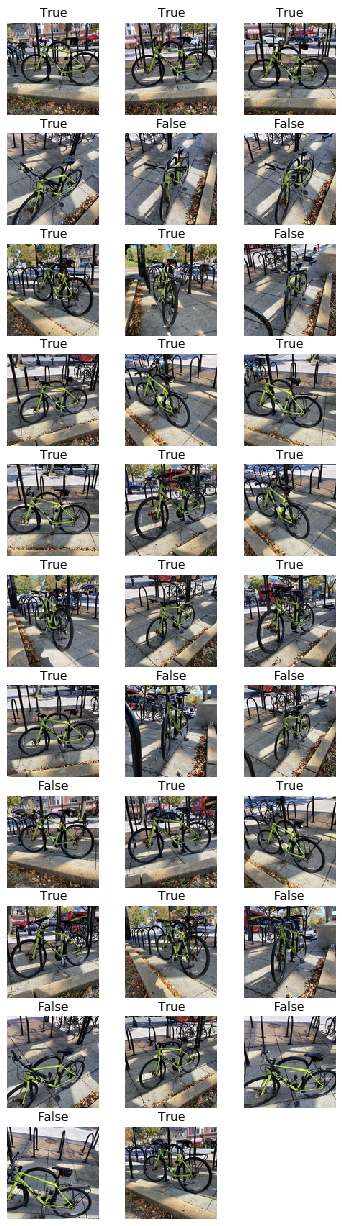

In [208]:
import matplotlib.pyplot as plt
import os
import math

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import json

#This is the directory, located inside
directory = "dataset/bicycle_capture_resize/test3"

# https://note.nkmk.me/en/python-pillow-square-circle-thumbnail/

# Center crops an image to get the desired width and height
def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

# Makes a square image
def crop_max_square(pil_img):
    return crop_center(pil_img, min(pil_img.size), min(pil_img.size))

image_size = int(os.environ.get('IMAGE_SIZE'))
use_grayscale = os.environ.get('USE_GRAYSCALE')
training_name = os.environ.get('TRAINING_NAME')
training_dir = os.environ.get('TRAINING_DIR')
if(use_grayscale == "True"):
    print("Using grayscale")

# The Int8 version of the TFLite model will be used
tflite_interpreter = tf.lite.Interpreter(model_path=training_dir +"/" + training_name + "/" + training_name + "_quantized-int8.tflite")
tflite_interpreter.allocate_tensors()


# It looks like it is impossible to batch inference with the TF1.0 TFLite interpertter: https://github.com/tensorflow/tensorflow/issues/38158
# doing 1 by 1 instead of as a batch

files = os.listdir(directory)
if (use_grayscale == "True"):
    raw_image_batch = np.empty((0, image_size, image_size), np.int8)
else:
    raw_image_batch = np.empty((0, image_size, image_size, 3), np.int8)
    
results = []
images_with_object = 0
for f in files:
    if f.endswith(".jpg"):
        if (use_grayscale == "True"):
            im = Image.open(directory+"/"+f).convert('L')
        else:
            im = Image.open(directory+"/"+f)

        # the input images are resized and square cropped to match the what the model expects
        im_thumb = crop_max_square(im).resize((image_size, image_size), Image.LANCZOS)
        input_data = np.array(im_thumb, dtype=np.uint8)
        input_data = np.expand_dims(input_data, axis=0)
        
        # The UInt8 version of the image is needed for plotting later on
        raw_image_batch = np.append(raw_image_batch, input_data, axis=0)
        
        # The input image data needs to be converted from UInt8 to Int8 for use with the model
        input_data = (input_data -128).astype(np.int8)


        # If it is a grayscale image we need to fill out the last axis of the array because it is expecting that shape
        if (use_grayscale == "True"):
            input_data = np.expand_dims(input_data, axis=3)

        tflite_interpreter.set_tensor(input_details[0]['index'], input_data)
        tflite_interpreter.invoke()
        predictions = tflite_interpreter.get_tensor(output_details[0]['index']).flatten()

        # parse the results for this image
        if (predictions[1] > predictions[0]):
            has_object = True
            images_with_object += 1
        else:
            has_object = False
        if f in labels:
            label = labels[f]
        else:
            label = None
        results.append({"prediction":has_object,"label":label})
        

# how many images are there
batch_size = np.size(raw_image_batch,axis=0)

# the outputted plot is going to have 3 columns, so figure out how many rows there should be
rows = math.ceil(batch_size/3)
plt.figure(figsize=(6, rows*2 ))



print("{} totals images, {} images were detected with object".format(batch_size, images_with_object))

# plot out each image, along with whether the object was detected in it
for i in range(batch_size):
  ax = plt.subplot( rows,3, i+1)
  if (use_grayscale == "True"):
    plt.imshow(raw_image_batch[i].astype("uint8"),cmap='gray')
  else:
    plt.imshow(raw_image_batch[i].astype("uint8"))

  plt.title(results[i]["prediction"])
  plt.axis("off")